<div style="text-align: right">INFO 6106 Neural Modeling, Final Project, Milestone 1</div>
<div style="text-align: right">Lokeshwaran Balamurugan, Nitin Sai Varma Indukuri, Krishica Gopalakrishnan</div>

# Final Project: Milestone 1: Part 3
<div style="text-align: center;">
    <img src="images/Long_Short_Term_Memory_(LSTM)_Models.jpg" width="400" />
</div>


## Objective
Preprocessing + Target Creation + Sliding Window Notebook: ( 30 marks )  
- Build a simple RNN baseline model using meteorological data.
- Use an architecture like LSTM or GRU or Transformers for time-series data.
    - Train the model with the sliding window inputs to predict precipitation_category.
- Evaluate the model:
    - Use metrics like accuracy and F1-score.
- Visualize training and validation loss/accuracy curves.
- Document observations, challenges, and initial results.


## 1. Import Libraries
Import essential libraries for data manipulation, visualization, image processing, and utility functions.

In [2]:
# Data Manipulation Libraries
import os
import pandas as pd
import numpy as np
import pickle
import ast

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

# Image Processing Libraries
from PIL import Image, ImageOps
import cv2

from imblearn.over_sampling import SMOTE

# Utility Libraries
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 2. Loading Data

Let's load the data that we have recieved as the output from our previous notebook.

In [8]:
from tqdm import tqdm
import numpy as np

# Define window sizes and corresponding number of images
window_sizes = [24, 48, 72]  # in hours
images_per_window_dict = {24: 8, 48: 16, 72: 24}

# Define the prediction shift for each window size
prediction_shifts = {24: 24, 48: 48, 72: 72}

# window_sizes = [24]  # in hours
# images_per_window_dict = {24: 8}

# # Define the prediction shift for each window size
# prediction_shifts = {24: 24}

# Define meteorological features to include
meteo_features = [
    'Temp_F', 'RH_pct', 'Dewpt_F', 'Wind_Spd_mph',
    'Wind_Direction_deg', 'Peak_Wind_Gust_mph',
    'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
    'High_Cloud_Ht_ft', 'Visibility_mi',
    'Atm_Press_hPa', 'Sea_Lev_Press_hPa',
    'Altimeter_hPa', 'Precip_in'
]

In [14]:
window_sizes = [24, 48, 72]  # in hours
images_per_window_dict = {24: 8, 48: 16, 72: 24}

# Directory to store preprocessed data
data_dir = r"\Users\nitin\Music\Neural Modeling Methods and Tools\Assignments\Final Project\data1"
os.makedirs(data_dir, exist_ok=True)

# Dictionary to hold filepaths for processed data, including timestamps
data_files = {
    window_size: {
        'X_meteo': os.path.join(data_dir, f"X_meteo_{window_size}.pkl"),
        'X_images': os.path.join(data_dir, f"X_images_{window_size}.pkl"),
        'y': os.path.join(data_dir, f"y_{window_size}.pkl"),
        'timestamps': os.path.join(data_dir, f"timestamps_{window_size}.pkl"),  # Add timestamps
    } for window_size in window_sizes
}

# Dictionary to store processed data
data_windows = {window_size: {'X_meteo': [], 'X_images': [], 'y': [], 'timestamps': []} for window_size in window_sizes}

for window_size in window_sizes:
    print(f"\nProcessing data for window size: {window_size} hours")
    
    # Prediction shift for the current window size
    prediction_shift = prediction_shifts[window_size]
    
    # Check if all files exist for this window size
    if all(os.path.exists(data_files[window_size][key]) for key in ['X_meteo', 'X_images', 'y']):
        print(f"Data exists for window size: {window_size}. Loading...")
        
        # Load preprocessed data
        with open(data_files[window_size]['X_meteo'], 'rb') as f:
            data_windows[window_size]['X_meteo'] = pickle.load(f)
        with open(data_files[window_size]['X_images'], 'rb') as f:
            data_windows[window_size]['X_images'] = pickle.load(f)
        with open(data_files[window_size]['y'], 'rb') as f:
            data_windows[window_size]['y'] = pickle.load(f)
        with open(data_files[window_size]['timestamps'], 'rb') as f:  # Load timestamps
            data_windows[window_size]['timestamps'] = pickle.load(f)
        
        print(f"Loaded data for window size {window_size}: "
              f"X_meteo shape {np.array(data_windows[window_size]['X_meteo']).shape}, "
              f"X_images shape {np.array(data_windows[window_size]['X_images']).shape}, "
              f"y shape {np.array(data_windows[window_size]['y']).shape}")
        

# Add corrupt_timestamps.pkl to data directory
corrupt_timestamps_path = os.path.join(data_dir, "corrupt_timestamps.pkl")

# Load corrupt timestamps
if os.path.exists(corrupt_timestamps_path):
    with open(corrupt_timestamps_path, 'rb') as f:
        data_windows["corrupt_timestamps"] = pickle.load(f)
    print(f"Loaded corrupt timestamps: {len(data_windows['corrupt_timestamps'])} entries found.")
              


Processing data for window size: 24 hours
Data exists for window size: 24. Loading...
Loaded data for window size 24: X_meteo shape (47834, 24, 14), X_images shape (47834, 32768), y shape (47834,)

Processing data for window size: 48 hours
Data exists for window size: 48. Loading...
Loaded data for window size 48: X_meteo shape (47786, 48, 14), X_images shape (47786, 65536), y shape (47786,)

Processing data for window size: 72 hours
Data exists for window size: 72. Loading...
Loaded data for window size 72: X_meteo shape (47738, 72, 14), X_images shape (47738, 98304), y shape (47738,)
Loaded corrupt timestamps: 2920 entries found.


In [15]:
# import numpy as np
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import StratifiedShuffleSplit

# # Function to display class distributions
# def print_class_distribution(y, name):
#     unique, counts = np.unique(y, return_counts=True)
#     print(f"\nClass distribution in {name}:")
#     for cls, count in zip(unique, counts):
#         print(f"  Class {cls}: {count} ({count / len(y) * 100:.2f}%)")

# # Function to split data and create balanced train/validation sets
# def prepare_data_24(data_windows, classes, samples_per_class=126):
#     # Load data for 24-hour window size
#     window_size = 24
#     X_meteo = data_windows[window_size]['X_meteo']
#     X_images = data_windows[window_size]['X_images'].reshape(-1, images_per_window_dict[window_size], 64, 64, 1)  # Reshape for CNN input
#     y = data_windows[window_size]['y']
#     timestamps = data_windows[window_size]['timestamps']
    
#     # Stratified split into train and temp (temp will later be split into balanced validation)
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#     for train_index, val_index in sss.split(X_meteo, y):
#         X_train_meteo, X_temp_meteo = X_meteo[train_index], X_meteo[val_index]
#         y_train, y_temp = y[train_index], y[val_index]
#         X_train_images, X_temp_images = X_images[train_index], X_images[val_index]
#         timestamps_train = timestamps[train_index]
#         timestamps_temp = timestamps[val_index]

#     # Create a balanced validation set with equal samples per class
#     balanced_val_indices = []
#     for c in classes:
#         class_indices = np.where(y_temp == c)[0]
#         if len(class_indices) < samples_per_class:
#             # Use replacement if not enough samples are available
#             balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=True))
#         else:
#             balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=False))

#     # Prepare balanced validation data
#     X_val_balanced_meteo = X_temp_meteo[balanced_val_indices]
#     X_val_balanced_images = X_temp_images[balanced_val_indices]
#     y_val_balanced = y_temp[balanced_val_indices]
#     timestamps_val_balanced = timestamps_temp[balanced_val_indices]

#     # One-hot encode the labels for train and validation
#     y_train_onehot = to_categorical(y_train, num_classes=len(classes))
#     y_val_balanced_onehot = to_categorical(y_val_balanced, num_classes=len(classes))

#     # Print class distributions
#     print_class_distribution(y_train, "Train Set")
#     print_class_distribution(y_val_balanced, "Balanced Validation Set")

#     return {
#         'X_train_meteo': X_train_meteo,
#         'X_train_images': X_train_images,
#         'y_train': y_train_onehot,
#         'timestamps_train': timestamps_train,
#         'X_val_meteo': X_val_balanced_meteo,
#         'X_val_images': X_val_balanced_images,
#         'y_val': y_val_balanced_onehot,
#         'timestamps_val': timestamps_val_balanced
#     }

# # Define classes
# classes = np.unique(data_windows[24]['y'])

# # Prepare train and validation data for 24-hour window size
# prepared_data_24 = prepare_data_24(data_windows, classes, samples_per_class=126)

# # Extract train and validation datasets
# X_train_24_meteo = prepared_data_24['X_train_meteo']
# X_train_24_images = prepared_data_24['X_train_images']
# y_train_24 = prepared_data_24['y_train']
# X_val_24_meteo = prepared_data_24['X_val_meteo']
# X_val_24_images = prepared_data_24['X_val_images']
# y_val_24 = prepared_data_24['y_val']
# timestamps_train = prepared_data_24['timestamps_train']
# timestamps_val = prepared_data_24['timestamps_val']

# # Verify the shapes of train and validation datasets
# print(f"\nShapes for 24-hour window size:")
# print(f"Train Meteo: {X_train_24_meteo.shape}, Train Images: {X_train_24_images.shape}, Train Labels: {y_train_24.shape}")
# print(f"Validation Meteo: {X_val_24_meteo.shape}, Validation Images: {X_val_24_images.shape}, Validation Labels: {y_val_24.shape}")

# 3. Handling Corrput Time Stamps

Here’s how we will approach the task of filtering out corrupt time stamps:
- <b>Iterate Through Each Window Size:</b> For each window size, we will loop through the timestamps associated with the sliding windows. Our goal will be to identify valid windows where none of the timestamps are part of the corrupt_timestamps list. 
- <b>Filter Valid Indices:</b> Using a list comprehension, we will check every sliding window's timestamps. If a window’s timestamps do not contain any corrupt entries, we will add that index to the list of valid indices for the respective window size.

In [16]:
# Dictionary to store valid indices for each window size
valid_indices_all = {}

# Calculate valid indices for each window size
for window_size in [24, 48, 72]:
    print(f"\nCalculating valid indices for window size: {window_size} hours")
    
    # Get valid indices
    valid_indices_all[window_size] = [
        idx
        for idx, timestamps in enumerate(data_windows[window_size]['timestamps'])
        if not any(ts in data_windows["corrupt_timestamps"] for ts in timestamps if ts != "No Image")
    ]
    
    print(f"Total valid windows ({window_size}): {len(valid_indices_all[window_size])} "
          f"out of {len(data_windows[window_size]['timestamps'])}")


Calculating valid indices for window size: 24 hours
Total valid windows (24): 39067 out of 47834

Calculating valid indices for window size: 48 hours
Total valid windows (48): 38995 out of 47786

Calculating valid indices for window size: 72 hours
Total valid windows (72): 38923 out of 47738


Now that we know which timestamps are corrputed, we are now going to filter them out:
- <b>Filter Data for Each Window Size:</b> 
    For each window size, we will:
    - Retrieve the valid indices from valid_indices_all that we calculated earlier.
    - Use these indices to filter the corresponding data in data_windows. This step ensures that only valid sliding windows are included, based on the clean timestamps.
- <b>Store the Filtered Data:</b> For each window size, we will store the filtered meteorological data, image data, target labels, and timestamps in filtered_data_all. This allows us to keep the data organized and ready for further processing.

In [56]:
# Dictionary to store filtered data for each window size
filtered_data_all = {}

# Filter data for each window size
for window_size in [24, 48, 72]:
    print(f"\nFiltering data for window size: {window_size} hours")
    
    valid_indices = valid_indices_all[window_size]
    
    # Filter the data
    filtered_data_all[window_size] = {
        'X_meteo': np.array(data_windows[window_size]['X_meteo'])[valid_indices],
        'X_images': np.array(data_windows[window_size]['X_images'])[valid_indices],
        'y': np.array(data_windows[window_size]['y'])[valid_indices],
        'timestamps': np.array(data_windows[window_size]['timestamps'])[valid_indices],
    }
    
    # Print shapes
    print(f"Filtered X_meteo shape ({window_size}): {filtered_data_all[window_size]['X_meteo'].shape}")
    print(f"Filtered X_images shape ({window_size}): {filtered_data_all[window_size]['X_images'].shape}")
    print(f"Filtered y shape ({window_size}): {filtered_data_all[window_size]['y'].shape}")
    print(f"Filtered timestamps shape ({window_size}): {filtered_data_all[window_size]['timestamps'].shape}")


Filtering data for window size: 24 hours
Filtered X_meteo shape (24): (39067, 24, 14)
Filtered X_images shape (24): (39067, 32768)
Filtered y shape (24): (39067,)
Filtered timestamps shape (24): (39067, 8)

Filtering data for window size: 48 hours
Filtered X_meteo shape (48): (38995, 48, 14)
Filtered X_images shape (48): (38995, 65536)
Filtered y shape (48): (38995,)
Filtered timestamps shape (48): (38995, 16)

Filtering data for window size: 72 hours
Filtered X_meteo shape (72): (38923, 72, 14)
Filtered X_images shape (72): (38923, 98304)
Filtered y shape (72): (38923,)
Filtered timestamps shape (72): (38923, 24)


# 4. Stratified Train-Test Splitting

Now, let us perform a train, test and validation split on the data. But, we will not split the data randomly like we normally do. 

- We are going to perfomr <b>Stratified Splitting</b>.
    - <b> What is Stratified Splitting of Data?</b>  
        A stratified split is a method of dividing data into training and testing (or validation) subsets while preserving the relative proportion of each class (or category) within the original dataset. This technique is commonly used in classification problems to ensure that all classes are fairly represented in both subsets.
- <b>Create a Balanced Validation Set:</b> Where we make sure that every class in the validation set has an equal number of samples, avoiding class imbalance during evaluation.
- <b>One Hot Encode Labels:</b> We convert both training and validation sets into one-hot encoded format. 
    - <b>What is One Hot Encoding?</b>
         One-hot encoding is a technique used to represent categorical data as a binary matrix. Each category is converted into a unique vector with binary values (0 and 1), where only one element is set to 1 to indicate the presence of that category, and all other elements are set to 0.

In [57]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical
import numpy as np

# Function to display class distributions
def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution in {name}:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} ({count / len(y) * 100:.2f}%)")

# Function to split data and create balanced train/validation sets
def prepare_data_stratified(data, classes, test_size=0.2, samples_per_class=126):
    """
    Stratified split of data into train and validation sets with balanced validation classes.

    Args:
        data (dict): Filtered data for a specific window size.
        classes (array): Unique classes in the dataset.
        test_size (float): Proportion of data to use for validation.
        samples_per_class (int): Number of samples per class for the balanced validation set.

    Returns:
        dict: Train and validation datasets for the window size.
    """
    X_meteo = data['X_meteo']
    X_images = data['X_images'].reshape(-1, images_per_window_dict[len(X_meteo[0])], 64, 64, 1)
    y = data['y']
    timestamps = data['timestamps']

    # Stratified split into train and temp (temp will later be split into balanced validation)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, val_index in sss.split(X_meteo, y):
        X_train_meteo, X_temp_meteo = X_meteo[train_index], X_meteo[val_index]
        y_train, y_temp = y[train_index], y[val_index]
        X_train_images, X_temp_images = X_images[train_index], X_images[val_index]
        timestamps_train = timestamps[train_index]
        timestamps_temp = timestamps[val_index]

    # Create a balanced validation set with equal samples per class
    balanced_val_indices = []
    for c in classes:
        class_indices = np.where(y_temp == c)[0]
        if len(class_indices) < samples_per_class:
            balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=True))
        else:
            balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=False))

    # Prepare balanced validation data
    X_val_balanced_meteo = X_temp_meteo[balanced_val_indices]
    X_val_balanced_images = X_temp_images[balanced_val_indices]
    y_val_balanced = y_temp[balanced_val_indices]
    timestamps_val_balanced = timestamps_temp[balanced_val_indices]

    # One-hot encode the labels for train and validation
    y_train_onehot = to_categorical(y_train, num_classes=len(classes))
    y_val_balanced_onehot = to_categorical(y_val_balanced, num_classes=len(classes))

    # Print class distributions
    print_class_distribution(y_train, "Train Set")
    print_class_distribution(y_val_balanced, "Balanced Validation Set")

    return {
        'X_train_meteo': X_train_meteo,
        'X_train_images': X_train_images,
        'y_train': y_train_onehot,
        'timestamps_train': timestamps_train,
        'X_val_meteo': X_val_balanced_meteo,
        'X_val_images': X_val_balanced_images,
        'y_val': y_val_balanced_onehot,
        'timestamps_val': timestamps_val_balanced,
    }

# Prepare train and validation data for all window sizes
prepared_data_all = {}

for window_size in [24, 48, 72]:
    print(f"\nPreparing stratified data split for {window_size}-hour window.")
    classes = np.unique(filtered_data_all[window_size]['y'])
    prepared_data_all[window_size] = prepare_data_stratified(filtered_data_all[window_size], classes)

    # Print dataset shapes
    print(f"\nShapes for {window_size}-hour window size:")
    print(f"Train Meteo: {prepared_data_all[window_size]['X_train_meteo'].shape}, ")
    print(f"Train Images: {prepared_data_all[window_size]['X_train_images'].shape}, ")
    print(f"Train Labels: {prepared_data_all[window_size]['y_train'].shape}")
    print(f"Validation Meteo: {prepared_data_all[window_size]['X_val_meteo'].shape}, ")
    print(f"Validation Images: {prepared_data_all[window_size]['X_val_images'].shape}, ")
    print(f"Validation Labels: {prepared_data_all[window_size]['y_val'].shape}")



Preparing stratified data split for 24-hour window.

Class distribution in Train Set:
  Class 0: 422 (1.35%)
  Class 1: 1029 (3.29%)
  Class 2: 783 (2.51%)
  Class 3: 29019 (92.85%)

Class distribution in Balanced Validation Set:
  Class 0: 126 (25.00%)
  Class 1: 126 (25.00%)
  Class 2: 126 (25.00%)
  Class 3: 126 (25.00%)

Shapes for 24-hour window size:
Train Meteo: (31253, 24, 14), 
Train Images: (31253, 8, 64, 64, 1), 
Train Labels: (31253, 4)
Validation Meteo: (504, 24, 14), 
Validation Images: (504, 8, 64, 64, 1), 
Validation Labels: (504, 4)

Preparing stratified data split for 48-hour window.

Class distribution in Train Set:
  Class 0: 421 (1.35%)
  Class 1: 1027 (3.29%)
  Class 2: 783 (2.51%)
  Class 3: 28965 (92.85%)

Class distribution in Balanced Validation Set:
  Class 0: 126 (25.00%)
  Class 1: 126 (25.00%)
  Class 2: 126 (25.00%)
  Class 3: 126 (25.00%)

Shapes for 48-hour window size:
Train Meteo: (31196, 48, 14), 
Train Images: (31196, 16, 64, 64, 1), 
Train Labels:

## 5. Feature Importance

- In order for us to analyze the meterological data, to predict outcomes, we can make the process more efficient by choosing the most important featurfes to predict the outcomes.
- To do this, we’ll train a Random Forest model, which will help us evaluate how much each feature contributes to making accurate predictions. 
- As soon as that is done, we'll calculate average importance scores for each feature, sort them by relevance, and pick the top ones. This process will allow us to focus on the key factors driving predictions, making our analysis more streamlined and efficient.

<b>Helper Function: Compute Top Features</b>

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Compute top features (meteorological data only) after filtering
def compute_top_features_filtered(X_train_meteo, y_train, top_n=10):
    # Flatten the meteorological data
    X_flat = X_train_meteo.reshape(X_train_meteo.shape[0], -1)
    
    # Initialize and train the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_flat, y_train.argmax(axis=1))  # Convert one-hot to class indices
    
    # Get feature importances
    feature_importance = rf.feature_importances_
    
    # Reshape importance to match original feature structure
    reshaped_importance = feature_importance.reshape(X_train_meteo.shape[1], -1)
    
    # Aggregate importance across features
    aggregated_importance = reshaped_importance.mean(axis=0)
    
    # Create a DataFrame for easier handling
    importance_df = pd.DataFrame({
        'Feature': [f"Feature {i}" for i in range(X_train_meteo.shape[2])],
        'Importance': aggregated_importance
    })
    
    # Sort features by importance
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Select top_n features
    top_features = importance_df.head(top_n).index.tolist()
    
    return top_features

Now, we'll use the helper function we defined above, to do the following:
- <b>Iterate over Window Sizes</b> (24, 48, and 72 hours)
- <b>Identify Top Features:</b> Using the helper function to compute the top features, we compute the average feature importance, and select a number of top contenders to be the most important features.
- <b>Reduce Meteorological Data: </b>We’ll filter the training and validation meteorological data, keeping only the identified top features. This reduction helps streamline the dataset without losing critical information.

In [ ]:
# Dictionary to store reduced data for all window sizes
reduced_data_filtered_all = {}

# Function to compute top features for all window sizes
for window_size in tqdm([24, 48, 72]):
    print(f"\nComputing top features for window size: {window_size} hours")

    # Extract train data for the current window size
    X_train_meteo = prepared_data_all[window_size]['X_train_meteo']
    y_train = prepared_data_all[window_size]['y_train']
    
    # Compute top features
    top_features_filtered = compute_top_features_filtered(
        X_train_meteo,
        y_train,
        top_n=10
    )
    print(f"Top 10 Features for {window_size}-hour Window (Filtered): {top_features_filtered}")

    # Reduce meteorological data to the top features
    X_train_meteo_reduced = X_train_meteo[:, :, top_features_filtered]
    X_val_meteo_reduced = prepared_data_all[window_size]['X_val_meteo'][:, :, top_features_filtered]

    # Store reduced data for the current window size
    reduced_data_filtered_all[window_size] = {
        'X_train_meteo': X_train_meteo_reduced,
        'X_train_images': prepared_data_all[window_size]['X_train_images'],
        'y_train': prepared_data_all[window_size]['y_train'],
        'timestamps_train': prepared_data_all[window_size]['timestamps_train'],
        'X_val_meteo': X_val_meteo_reduced,
        'X_val_images': prepared_data_all[window_size]['X_val_images'],
        'y_val': prepared_data_all[window_size]['y_val'],
        'timestamps_val': prepared_data_all[window_size]['timestamps_val'],
    }

    # Print reduced shapes
    print(f"Reduced Train Meteo Shape ({window_size}): {X_train_meteo_reduced.shape}")
    print(f"Reduced Validation Meteo Shape ({window_size}): {X_val_meteo_reduced.shape}")

  0%|          | 0/3 [00:00<?, ?it/s]


Computing top features for window size: 24 hours


 33%|███▎      | 1/3 [00:46<01:32, 46.37s/it]

Top 10 Features for 24-hour Window (Filtered): [1, 11, 0, 2, 12, 10, 6, 4, 3, 7]
Reduced Train Meteo Shape (24): (31253, 24, 10)
Reduced Validation Meteo Shape (24): (504, 24, 10)

Computing top features for window size: 48 hours


 67%|██████▋   | 2/3 [01:54<00:58, 59.00s/it]

Top 10 Features for 48-hour Window (Filtered): [1, 0, 12, 11, 2, 6, 10, 3, 4, 7]
Reduced Train Meteo Shape (48): (31196, 48, 10)
Reduced Validation Meteo Shape (48): (504, 48, 10)

Computing top features for window size: 72 hours


100%|██████████| 3/3 [03:30<00:00, 70.23s/it]

Top 10 Features for 72-hour Window (Filtered): [1, 0, 12, 2, 11, 10, 6, 3, 4, 7]
Reduced Train Meteo Shape (72): (31138, 72, 10)
Reduced Validation Meteo Shape (72): (504, 72, 10)


In [60]:
def display_first_n_samples(reduced_data, window_size=24, num_samples=20):
    """
    Display the first n samples of the filtered and reduced data, 
    showing meteorological data, associated images with timestamps, and target labels.
    
    Args:
        reduced_data (dict): Contains 'X_train_meteo', 'X_train_images', 'y_train', 'timestamps_train', 
                             'X_val_meteo', 'X_val_images', 'y_val', 'timestamps_val' for each window size.
        window_size (int): Size of the window (24, 48, 72 hours).
        num_samples (int): Number of samples to display.
    """
    # Extract training data
    X_meteo = reduced_data[window_size]['X_train_meteo']
    X_images = reduced_data[window_size]['X_train_images']
    y = reduced_data[window_size]['y_train']
    timestamps = reduced_data[window_size]['timestamps_train']
    
    # Convert one-hot labels to class indices
    y_labels = np.argmax(y, axis=1)
    
    # Define feature column names for meteorological data
    top_features = [
        f"Feature {i}" for i in range(X_meteo.shape[2])
    ]  # Adjusted to match the reduced features
    
    # Define class names based on unique classes
    num_classes = y.shape[1]
    class_names = [f"Class {i}" for i in range(num_classes)]
    
    for i in range(min(num_samples, len(X_meteo))):
        print(f"\n=== Sample {i+1} ===")
        print(f"Target (y): {class_names[y_labels[i]]}")
        print("Meteorological Data:")
        
        # Create a DataFrame for meteorological data
        meteo_df = pd.DataFrame(X_meteo[i], columns=top_features)
        display(meteo_df)
        
        # Plot images with timestamps
        images = X_images[i]  # Shape: (num_images, 64, 64, 1)
        num_images = images.shape[0]
        
        # Create a figure with subplots
        fig, axes = plt.subplots(1, num_images, figsize=(20, 3))
        fig.suptitle(f"Sample {i+1} Images ({window_size}-hour Window)", fontsize=16)
        
        for j in range(num_images):
            img = images[j].reshape(64, 64)  # Reshape image
            ax = axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            # Get corresponding timestamp
            ts = timestamps[i][j] if j < len(timestamps[i]) else "No Image"
            ax.set_title(ts if ts != "No Image" else "Placeholder")
        
        plt.tight_layout()
        plt.show()


=== Sample 1 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,88.0,1024.6,42.0,39.0,1024.0,1001.0,1100.0,80.0,5.0,0.0
1,88.0,1024.7,42.0,39.0,1024.4,1001.3,1100.0,70.0,3.0,0.0
2,88.0,1024.6,43.0,40.0,1024.0,1001.0,1100.0,80.0,6.0,0.0
3,85.0,1024.4,44.0,40.0,1024.0,1001.0,1100.0,90.0,7.0,0.0
4,82.0,1023.6,45.0,40.0,1023.0,1000.0,1100.0,120.0,8.0,0.0
5,79.0,1022.9,46.0,40.0,1022.4,999.3,1300.0,130.0,8.0,0.0
6,73.0,1021.7,48.0,40.0,1021.3,998.3,1600.0,100.0,11.0,0.0
7,68.0,1021.5,49.0,39.0,1021.0,998.0,2200.0,0.0,7.0,0.0
8,70.0,0.0,48.0,39.0,1021.3,998.3,2200.0,110.0,8.0,6000.0
9,73.0,1022.2,46.0,38.0,1021.7,998.7,2000.0,140.0,6.0,0.0


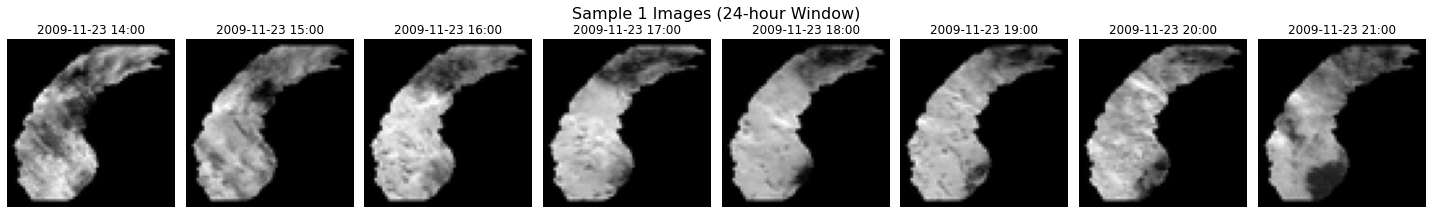


=== Sample 2 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,79.0,1003.7,48.0,42.0,1003.4,980.7,1800.0,240.0,8.0,2500.0
1,73.0,1003.1,48.0,40.0,1002.7,980.0,1800.0,240.0,10.0,2700.0
2,70.0,1002.6,48.0,39.0,1002.4,979.7,2500.0,250.0,11.0,0.0
3,70.0,1003.1,47.0,38.0,1002.7,980.0,2300.0,250.0,11.0,0.0
4,73.0,1003.9,46.0,38.0,1003.7,981.0,2300.0,270.0,9.0,0.0
5,73.0,1004.2,46.0,38.0,1004.1,981.4,2300.0,270.0,6.0,0.0
6,76.0,1004.7,44.0,37.0,1004.4,981.7,2300.0,290.0,7.0,0.0
7,76.0,1004.6,43.0,36.0,1004.4,981.7,2300.0,290.0,6.0,0.0
8,76.0,1005.0,43.0,36.0,1004.7,982.0,2000.0,0.0,0.0,0.0
9,85.0,1005.0,41.0,37.0,1004.7,982.0,2000.0,0.0,0.0,0.0


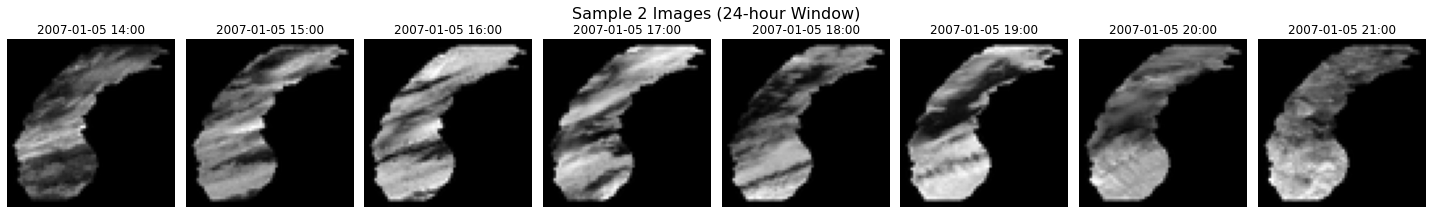


=== Sample 3 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,93.0,0.0,45.0,43.0,1010.5,987.7,700.0,0.0,0.0,1300.0
1,96.0,1011.0,43.0,42.0,1010.5,987.7,700.0,0.0,0.0,0.0
2,96.0,1010.8,43.0,42.0,1010.5,987.7,600.0,0.0,0.0,1100.0
3,96.0,1010.4,43.0,42.0,1010.2,987.3,500.0,0.0,0.0,0.0
4,100.0,0.0,43.0,43.0,1009.8,987.0,500.0,0.0,0.0,0.0
5,88.0,1020.1,37.0,34.0,1019.6,996.7,1200.0,100.0,8.0,0.0
6,85.0,1018.9,38.0,34.0,1018.3,995.3,1200.0,110.0,8.0,0.0
7,85.0,1018.3,38.0,34.0,1017.6,994.7,1200.0,120.0,7.0,0.0
8,89.0,1017.6,38.0,35.0,1016.9,994.0,1100.0,0.0,5.0,0.0
9,89.0,1017.0,38.0,35.0,1016.6,993.7,1100.0,110.0,3.0,0.0


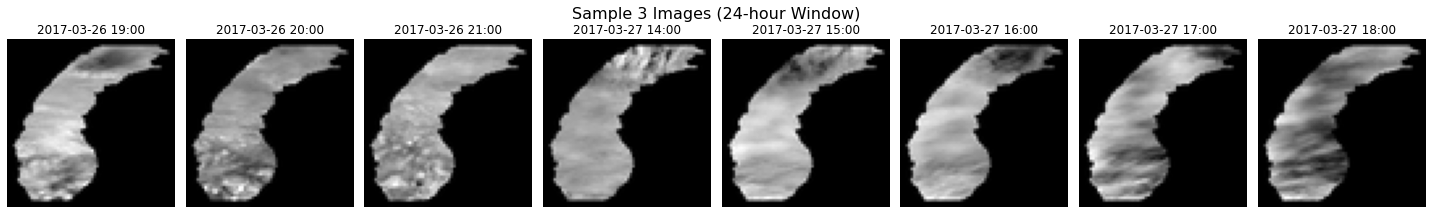


=== Sample 4 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,77.0,1025.8,24.0,18.0,1024.7,1001.6,1300.0,340.0,10.0,20000.0
1,74.0,1026.4,24.0,17.0,1025.4,1002.3,1500.0,360.0,8.0,0.0
2,70.0,1026.7,24.0,16.0,1025.7,1002.6,1700.0,360.0,8.0,0.0
3,68.0,1027.3,24.0,15.0,1026.4,1003.3,1900.0,360.0,6.0,0.0
4,71.0,1027.7,23.0,15.0,1026.8,1003.6,2100.0,360.0,5.0,0.0
5,73.0,1027.9,19.0,12.0,1026.8,1003.6,2100.0,90.0,7.0,0.0
6,76.0,1028.6,17.0,11.0,1027.4,1004.3,2100.0,0.0,0.0,0.0
7,88.0,1029.0,13.0,10.0,1027.8,1004.6,0.0,0.0,0.0,0.0
8,79.0,1029.6,9.0,4.0,1028.4,1005.3,2200.0,0.0,0.0,0.0
9,91.0,1029.2,5.0,3.0,1027.8,1004.6,0.0,0.0,0.0,0.0


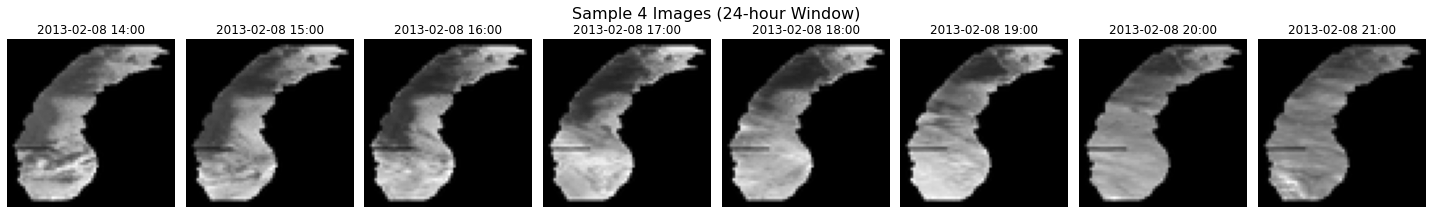


=== Sample 5 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,75.0,1025.6,10.0,4.0,1024.4,1001.3,5000.0,210.0,8.0,0.0
1,75.0,1025.7,10.0,4.0,1024.4,1001.3,4900.0,220.0,8.0,0.0
2,72.0,1026.5,10.0,3.0,1025.1,1002.0,2800.0,0.0,7.0,4700.0
3,72.0,1027.0,10.0,3.0,1025.7,1002.6,2500.0,210.0,6.0,4500.0
4,72.0,1027.1,10.0,3.0,1025.7,1002.6,4900.0,200.0,6.0,0.0
5,76.0,1026.8,9.0,3.0,1025.4,1002.3,4400.0,210.0,6.0,0.0
6,61.0,1033.8,14.0,3.0,1032.5,1009.3,3800.0,310.0,10.0,0.0
7,63.0,1034.7,14.0,4.0,1033.2,1010.0,3600.0,310.0,11.0,0.0
8,66.0,1035.0,15.0,6.0,1033.9,1010.6,3600.0,290.0,10.0,0.0
9,64.0,1035.4,16.0,6.0,1034.2,1011.0,3600.0,250.0,7.0,0.0


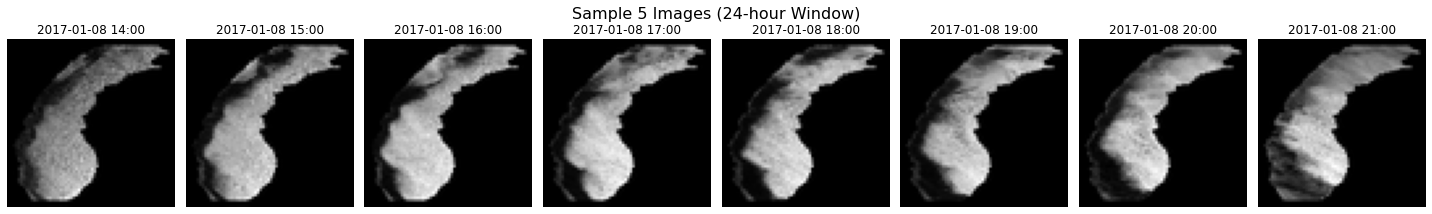


=== Sample 6 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,77.0,1020.1,20.0,14.0,1019.3,996.3,11000.0,160.0,5.0,0.0
1,77.0,1020.0,21.0,15.0,1019.0,996.0,11000.0,140.0,7.0,12000.0
2,77.0,1019.1,22.0,16.0,1017.9,995.0,11000.0,160.0,7.0,20000.0
3,68.0,1017.5,26.0,17.0,1016.6,993.7,15000.0,150.0,6.0,25000.0
4,63.0,1015.8,30.0,19.0,1014.9,992.0,15000.0,140.0,7.0,25000.0
5,58.0,1015.3,33.0,20.0,1014.6,991.7,6500.0,130.0,6.0,9000.0
6,56.0,1014.0,36.0,22.0,1013.2,990.3,4200.0,0.0,5.0,9000.0
7,59.0,0.0,36.0,23.0,1011.9,989.0,2000.0,150.0,8.0,5000.0
8,66.0,1010.3,36.0,26.0,1009.5,986.7,2900.0,140.0,7.0,3800.0
9,64.0,1008.9,36.0,25.0,1008.1,985.4,3600.0,130.0,7.0,4300.0


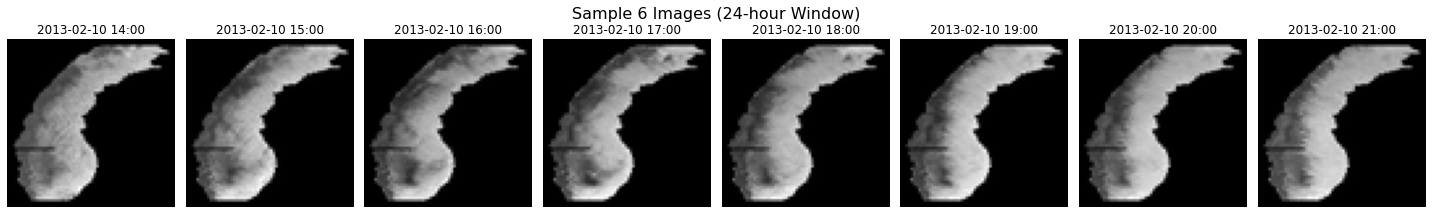


=== Sample 7 ===
Target (y): Class 2
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,73.0,0.0,27.0,19.0,1015.2,992.3,2400.0,240.0,10.0,4000.0
1,71.0,1016.1,25.0,17.0,1015.2,992.3,2600.0,240.0,8.0,3600.0
2,74.0,1015.8,25.0,18.0,1014.9,992.0,2300.0,240.0,6.0,3600.0
3,77.0,1015.7,25.0,19.0,1014.9,992.0,3000.0,0.0,7.0,0.0
4,85.0,0.0,25.0,21.0,1014.9,992.0,2000.0,190.0,5.0,0.0
5,87.0,1016.1,25.0,22.0,1015.2,992.3,1800.0,180.0,3.0,2700.0
6,87.0,1016.6,25.0,22.0,1015.6,992.7,1800.0,210.0,6.0,3200.0
7,85.0,0.0,25.0,21.0,1015.9,993.0,2600.0,220.0,5.0,3300.0
8,85.0,0.0,25.0,21.0,1015.9,993.0,800.0,200.0,5.0,1600.0
9,77.0,1017.4,25.0,19.0,1016.6,993.7,1800.0,230.0,9.0,3800.0


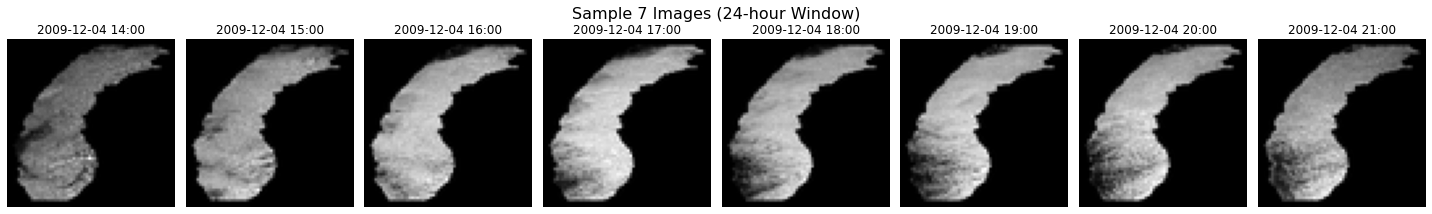


=== Sample 8 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,92.0,1013.9,40.0,38.0,1013.5,990.7,25000.0,0.0,0.0,0.0
1,79.0,1013.8,50.0,44.0,1013.5,990.7,25000.0,0.0,0.0,0.0
2,63.0,1013.9,57.0,45.0,1013.5,990.7,25000.0,0.0,5.0,0.0
3,59.0,1013.6,61.0,47.0,1013.2,990.3,3500.0,0.0,6.0,25000.0
4,55.0,1013.4,61.0,45.0,1013.2,990.3,3000.0,240.0,5.0,25000.0
5,44.0,1012.5,63.0,41.0,1012.5,989.7,4000.0,260.0,6.0,25000.0
6,44.0,1011.7,65.0,43.0,1011.5,988.7,4000.0,0.0,7.0,25000.0
7,43.0,1011.3,65.0,42.0,1011.2,988.3,3000.0,250.0,6.0,15000.0
8,48.0,1011.0,64.0,44.0,1010.8,988.0,3000.0,0.0,0.0,15000.0
9,64.0,1010.7,61.0,49.0,1010.5,987.7,15000.0,0.0,0.0,25000.0


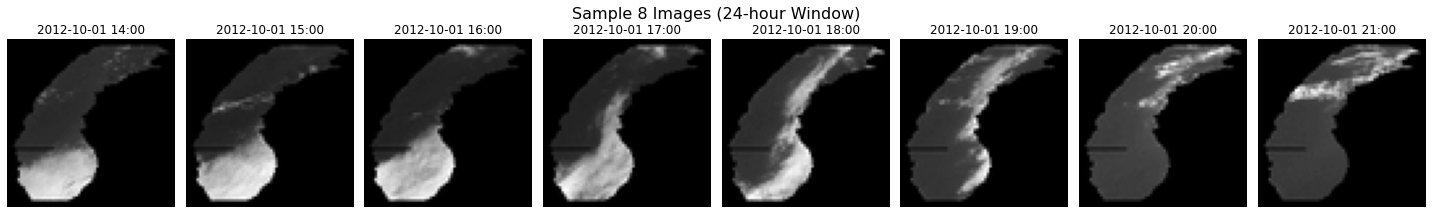


=== Sample 9 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,67.0,1021.2,21.0,12.0,1020.3,997.3,2000.0,110.0,6.0,20000.0
1,64.0,1021.4,23.0,13.0,1020.3,997.3,2000.0,0.0,0.0,20000.0
2,59.0,1020.4,25.0,13.0,1019.6,996.7,20000.0,0.0,0.0,0.0
3,60.0,1019.4,27.0,15.0,1018.3,995.3,20000.0,50.0,13.0,0.0
4,57.0,1018.7,28.0,15.0,1017.6,994.7,20000.0,50.0,9.0,0.0
5,53.0,1018.7,30.0,15.0,1017.6,994.7,20000.0,40.0,7.0,0.0
6,55.0,1019.4,29.0,15.0,1018.6,995.7,20000.0,0.0,0.0,0.0
7,57.0,1020.0,27.0,14.0,1019.0,996.0,20000.0,0.0,0.0,0.0
8,64.0,1020.2,24.0,14.0,1019.3,996.3,20000.0,0.0,0.0,0.0
9,76.0,1020.7,19.0,13.0,1019.6,996.7,0.0,0.0,0.0,0.0


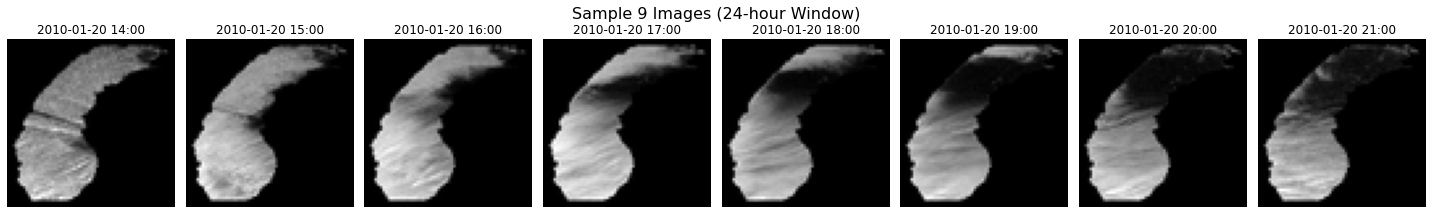


=== Sample 10 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,72.0,1014.0,34.0,26.0,1013.5,990.7,2200.0,240.0,9.0,2900.0
1,75.0,1013.8,34.0,27.0,1013.2,990.3,2000.0,240.0,11.0,0.0
2,84.0,1013.0,33.0,29.0,1012.2,989.3,2100.0,240.0,7.0,0.0
3,80.0,0.0,34.0,28.0,1011.5,988.7,2300.0,240.0,8.0,3000.0
4,81.0,1011.5,34.0,29.0,1010.8,988.0,2900.0,250.0,9.0,0.0
5,81.0,1011.6,34.0,29.0,1010.8,988.0,2700.0,260.0,8.0,0.0
6,84.0,1013.0,20.0,16.0,1012.2,989.3,1200.0,60.0,6.0,2000.0
7,80.0,1013.6,21.0,16.0,1012.5,989.7,3200.0,40.0,7.0,0.0
8,77.0,1014.0,21.0,15.0,1013.2,990.3,1800.0,40.0,7.0,4200.0
9,74.0,1014.5,22.0,15.0,1013.5,990.7,2000.0,30.0,8.0,6500.0


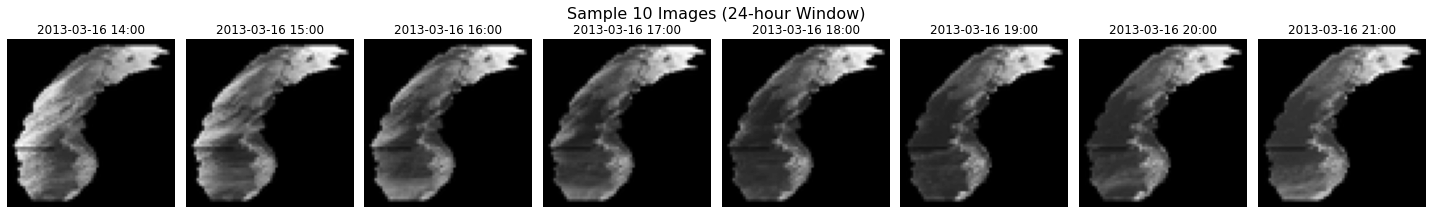


=== Sample 11 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,66.0,1036.8,12.0,3.0,1035.6,1012.3,5000.0,330.0,16.0,0.0
1,72.0,1037.6,11.0,4.0,1036.2,1012.9,4200.0,330.0,13.0,0.0
2,66.0,1038.1,11.0,2.0,1036.9,1013.6,3700.0,310.0,11.0,0.0
3,83.0,1033.0,4.0,-0.0,1031.5,1008.3,3000.0,0.0,0.0,10000.0
4,79.0,1032.5,7.0,2.0,1031.2,1008.0,11000.0,0.0,0.0,0.0
5,67.0,1032.2,16.0,7.0,1030.8,1007.6,11000.0,190.0,7.0,20000.0
6,62.0,1031.7,21.0,10.0,1030.5,1007.3,9500.0,190.0,8.0,20000.0
7,59.0,1030.8,24.0,12.0,1029.5,1006.3,9000.0,200.0,9.0,20000.0
8,52.0,1029.6,27.0,12.0,1028.4,1005.3,2300.0,0.0,6.0,8500.0
9,55.0,1028.9,29.0,15.0,1027.8,1004.6,2500.0,250.0,13.0,9000.0


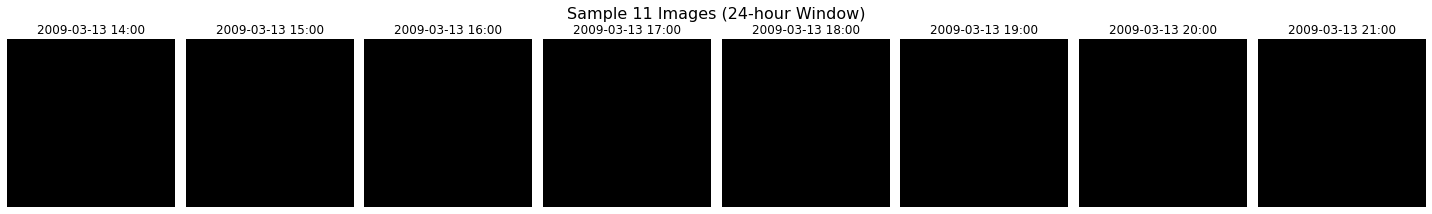


=== Sample 12 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,83.0,1021.5,10.0,6.0,1020.3,997.3,400.0,100.0,7.0,1300.0
1,73.0,1022.9,13.0,6.0,1021.7,998.7,1100.0,20.0,11.0,2000.0
2,69.0,1024.1,12.0,4.0,1022.7,999.6,1600.0,60.0,8.0,2200.0
3,80.0,1024.9,13.0,8.0,1023.4,1000.3,1600.0,70.0,9.0,2700.0
4,55.0,1025.1,15.0,2.0,1023.7,1000.6,2200.0,360.0,10.0,3400.0
5,58.0,1025.6,15.0,3.0,1024.4,1001.3,3500.0,20.0,13.0,4500.0
6,58.0,1025.9,16.0,4.0,1024.4,1001.3,3500.0,350.0,9.0,4400.0
7,72.0,0.0,16.0,9.0,1025.1,1002.0,1800.0,330.0,9.0,3000.0
8,70.0,1026.8,17.0,9.0,1025.4,1002.3,1800.0,330.0,7.0,2800.0
9,83.0,1027.5,15.0,11.0,1026.1,1003.0,800.0,290.0,3.0,1600.0


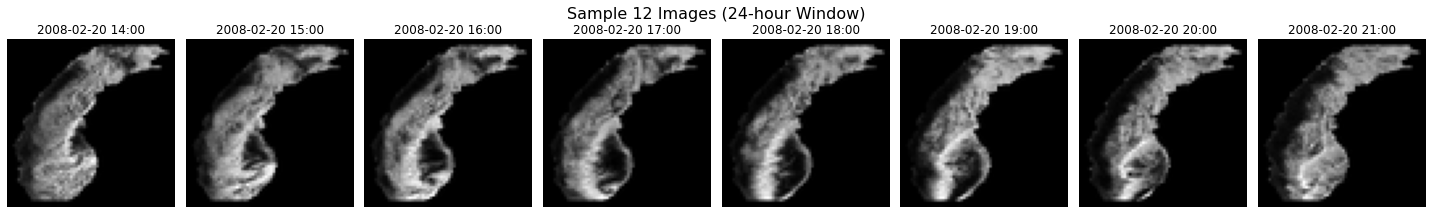


=== Sample 13 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,78.0,1010.4,32.0,26.0,1009.5,986.7,2500.0,250.0,6.0,3700.0
1,72.0,1010.8,32.0,24.0,1009.8,987.0,3700.0,270.0,14.0,4400.0
2,81.0,1011.8,30.0,25.0,1011.2,988.3,1500.0,330.0,8.0,2200.0
3,68.0,1012.1,30.0,21.0,1011.2,988.3,2200.0,330.0,11.0,2700.0
4,77.0,1019.2,23.0,17.0,1018.3,995.3,1400.0,180.0,5.0,0.0
5,77.0,1018.3,24.0,18.0,1017.3,994.3,1400.0,0.0,3.0,0.0
6,77.0,1017.6,24.0,18.0,1016.6,993.7,1400.0,0.0,6.0,0.0
7,77.0,1016.8,24.0,18.0,1015.9,993.0,1400.0,180.0,6.0,0.0
8,80.0,1015.6,24.0,19.0,1014.6,991.7,1300.0,170.0,6.0,0.0
9,80.0,1014.8,24.0,19.0,1013.9,991.0,1200.0,170.0,5.0,0.0


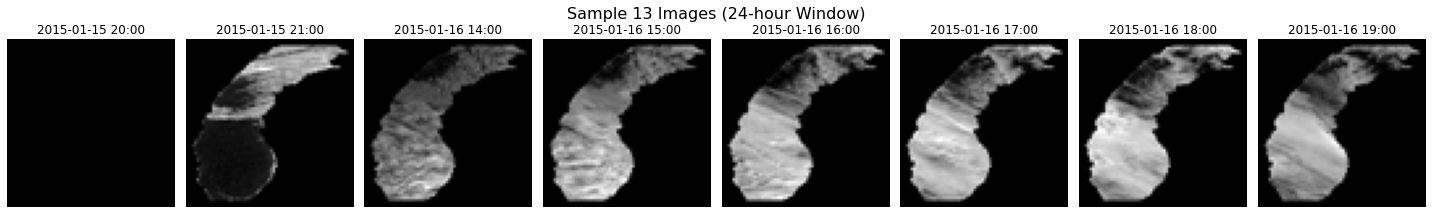


=== Sample 14 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,88.0,1020.2,29.0,26.0,1019.6,996.7,0.0,0.0,0.0,0.0
1,88.0,1020.9,28.0,25.0,1020.3,997.3,0.0,0.0,0.0,0.0
2,92.0,1021.2,26.0,24.0,1020.7,997.7,2000.0,0.0,0.0,0.0
3,88.0,1021.6,26.0,23.0,1021.0,998.0,2200.0,0.0,0.0,0.0
4,81.0,1018.6,36.0,31.0,1017.9,995.0,1200.0,0.0,7.0,2200.0
5,81.0,1017.9,36.0,31.0,1017.3,994.3,1400.0,130.0,9.0,2600.0
6,78.0,1017.2,37.0,31.0,1016.6,993.7,9500.0,120.0,7.0,20000.0
7,78.0,1016.1,37.0,31.0,1015.2,992.3,10000.0,120.0,6.0,0.0
8,72.0,1015.4,39.0,31.0,1014.6,991.7,10000.0,140.0,6.0,0.0
9,72.0,1014.1,39.0,31.0,1013.5,990.7,7500.0,120.0,11.0,9500.0


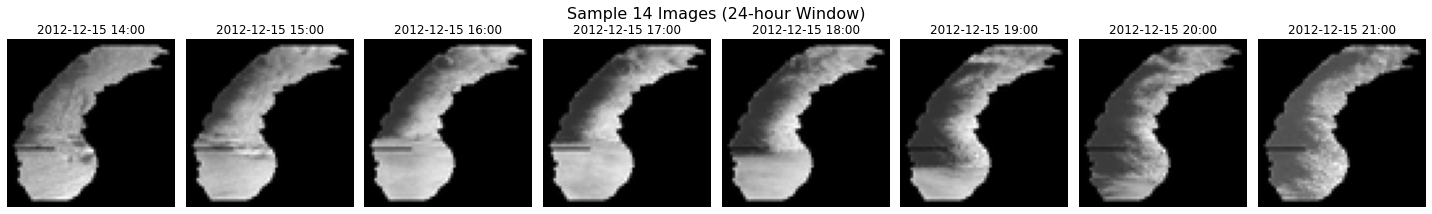


=== Sample 15 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,63.0,1005.0,34.0,23.0,1004.7,982.0,2600.0,250.0,16.0,0.0
1,77.0,1005.0,33.0,27.0,1004.7,982.0,2800.0,250.0,15.0,4500.0
2,84.0,1005.1,33.0,29.0,1004.7,982.0,1500.0,260.0,13.0,2300.0
3,69.0,1005.5,35.0,26.0,1005.1,982.4,3300.0,270.0,24.0,5000.0
4,69.0,1006.2,35.0,26.0,1005.8,983.0,2100.0,310.0,24.0,3500.0
5,74.0,0.0,34.0,27.0,1006.8,984.0,1900.0,290.0,23.0,3700.0
6,81.0,1008.4,32.0,27.0,1007.8,985.0,1400.0,300.0,20.0,0.0
7,63.0,1009.7,34.0,23.0,1009.1,986.4,2800.0,310.0,26.0,4000.0
8,71.0,1011.5,33.0,25.0,1010.8,988.0,2400.0,300.0,31.0,3300.0
9,69.0,1013.1,33.0,24.0,1012.5,989.7,2700.0,300.0,23.0,3500.0


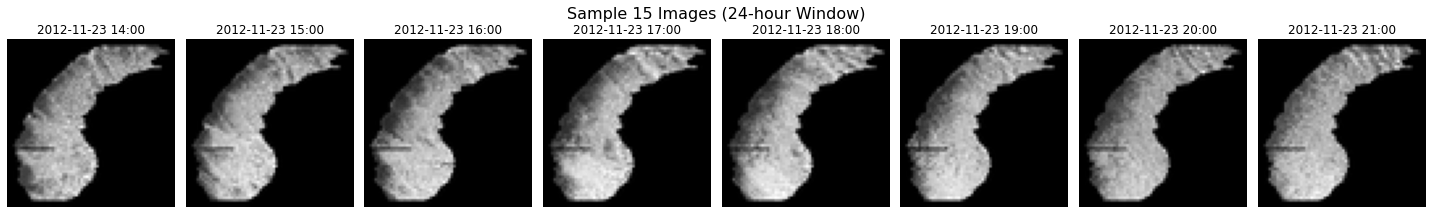


=== Sample 16 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,82.0,1009.2,40.0,35.0,1008.8,986.0,2800.0,280.0,10.0,3700.0
1,75.0,0.0,43.0,36.0,1009.1,986.4,3000.0,300.0,14.0,3800.0
2,75.0,1010.0,42.0,35.0,1009.5,986.7,2900.0,300.0,11.0,4100.0
3,62.0,1010.1,45.0,33.0,1009.5,986.7,3200.0,300.0,15.0,5000.0
4,54.0,1009.7,49.0,33.0,1009.1,986.4,3700.0,310.0,16.0,4600.0
5,55.0,1009.7,47.0,32.0,1009.1,986.4,3700.0,310.0,14.0,4900.0
6,60.0,1010.1,45.0,32.0,1009.8,987.0,4000.0,310.0,17.0,5500.0
7,70.0,1010.7,43.0,34.0,1010.5,987.7,2200.0,330.0,10.0,4000.0
8,72.0,1011.3,42.0,34.0,1010.8,988.0,3600.0,330.0,11.0,4400.0
9,85.0,1011.9,37.0,33.0,1011.5,988.7,1500.0,290.0,10.0,2600.0


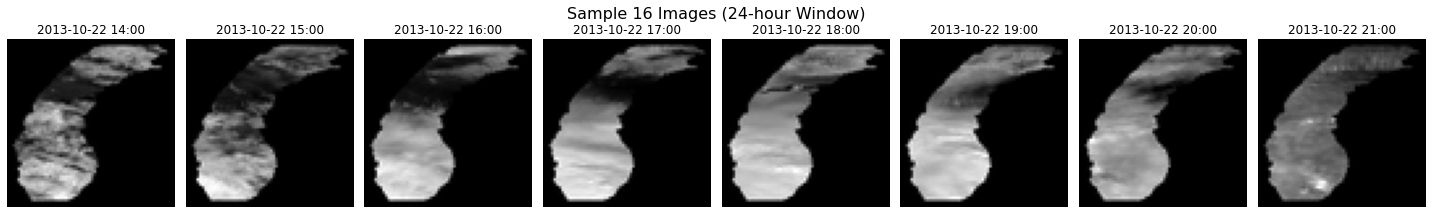


=== Sample 17 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,74.0,1013.3,59.0,51.0,1013.2,990.3,5000.0,0.0,0.0,0.0
1,86.0,1013.5,57.0,53.0,1013.5,990.7,3900.0,120.0,5.0,5000.0
2,89.0,1012.8,57.0,54.0,1012.5,989.7,1900.0,0.0,5.0,4700.0
3,86.0,1012.4,58.0,54.0,1012.2,989.3,5000.0,0.0,5.0,7000.0
4,93.0,1012.8,57.0,55.0,1012.5,989.7,1800.0,140.0,3.0,3300.0
5,90.0,1012.4,58.0,55.0,1012.2,989.3,1000.0,0.0,0.0,1400.0
6,93.0,1011.8,58.0,56.0,1011.9,989.0,1200.0,100.0,3.0,0.0
7,89.0,1010.5,60.0,57.0,1010.5,987.7,1300.0,110.0,6.0,2000.0
8,82.0,0.0,63.0,57.0,1010.2,987.3,1800.0,130.0,6.0,3100.0
9,86.0,1009.3,62.0,58.0,1009.5,986.7,1300.0,150.0,6.0,2000.0


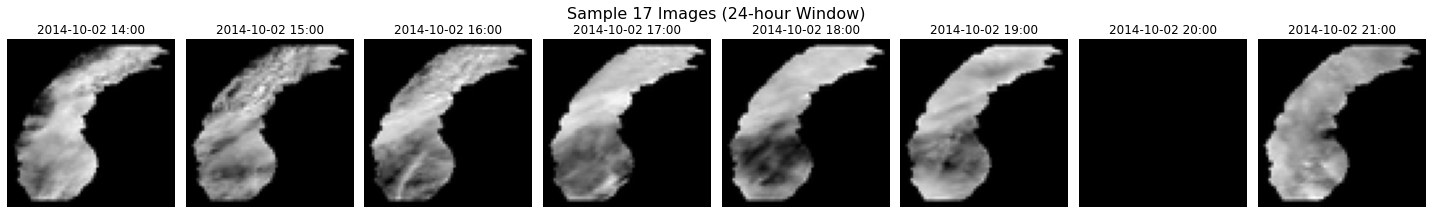


=== Sample 18 ===
Target (y): Class 1
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,82.0,1027.6,1.0,-3.0,1026.1,1003.0,2100.0,0.0,0.0,3100.0
1,83.0,1027.9,2.0,-2.0,1026.4,1003.3,3100.0,0.0,0.0,0.0
2,83.0,1027.5,2.0,-2.0,1026.1,1003.0,3100.0,0.0,0.0,0.0
3,83.0,1027.1,3.0,-1.0,1025.7,1002.6,3300.0,0.0,0.0,0.0
4,73.0,1017.5,19.0,12.0,1016.6,993.7,3600.0,360.0,10.0,0.0
5,79.0,0.0,18.0,12.0,1017.3,994.3,1800.0,350.0,10.0,2400.0
6,73.0,1019.2,17.0,10.0,1018.3,995.3,1900.0,300.0,10.0,3800.0
7,76.0,1019.6,16.0,10.0,1018.6,995.7,2600.0,270.0,8.0,3800.0
8,78.0,0.0,16.0,10.0,1019.3,996.3,2100.0,300.0,8.0,3400.0
9,76.0,1021.7,15.0,9.0,1020.7,997.7,5000.0,280.0,10.0,0.0


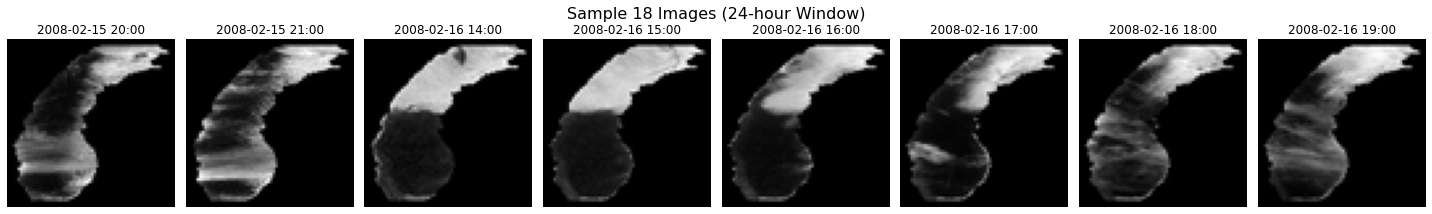


=== Sample 19 ===
Target (y): Class 2
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,62.0,1030.9,28.0,17.0,1030.1,1007.0,2300.0,340.0,5.0,0.0
1,71.0,1031.0,27.0,19.0,1030.1,1007.0,2300.0,70.0,5.0,0.0
2,68.0,1030.8,27.0,18.0,1029.8,1006.6,2300.0,0.0,0.0,0.0
3,74.0,1031.1,23.0,16.0,1030.1,1007.0,2100.0,80.0,3.0,0.0
4,78.0,1025.3,29.0,23.0,1024.7,1001.6,1700.0,360.0,10.0,0.0
5,74.0,1025.7,28.0,21.0,1025.1,1002.0,1900.0,350.0,10.0,0.0
6,74.0,1025.8,28.0,21.0,1025.1,1002.0,2000.0,360.0,6.0,0.0
7,74.0,1026.0,28.0,21.0,1025.4,1002.3,1600.0,360.0,8.0,0.0
8,73.0,0.0,27.0,19.0,1025.7,1002.6,1800.0,350.0,7.0,3400.0
9,71.0,1026.6,28.0,20.0,1025.7,1002.6,2400.0,350.0,5.0,0.0


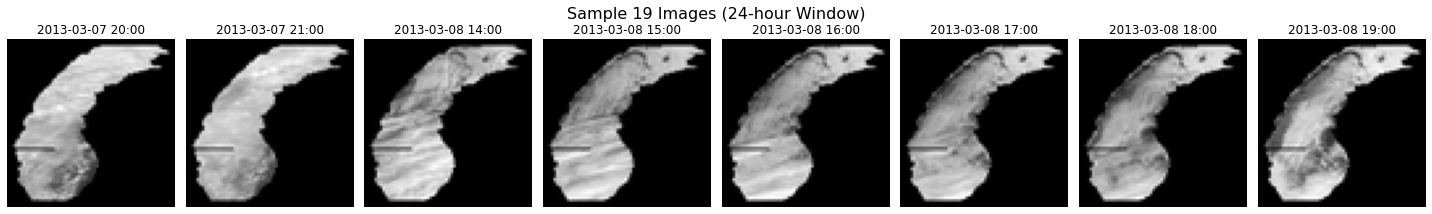


=== Sample 20 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,82.0,1017.9,45.0,40.0,1017.6,994.7,1200.0,110.0,8.0,0.0
1,82.0,1017.4,45.0,40.0,1016.9,994.0,1000.0,80.0,5.0,0.0
2,82.0,1017.3,45.0,40.0,1016.9,994.0,900.0,110.0,5.0,0.0
3,82.0,1016.6,45.0,40.0,1016.3,993.3,800.0,110.0,6.0,0.0
4,85.0,1015.8,44.0,40.0,1015.6,992.7,700.0,90.0,11.0,0.0
5,88.0,1015.2,44.0,41.0,1014.9,992.0,700.0,90.0,6.0,0.0
6,89.0,994.0,57.0,54.0,993.9,971.4,4400.0,0.0,5.0,5500.0
7,89.0,992.5,57.0,54.0,992.6,970.1,4000.0,130.0,7.0,4900.0
8,86.0,991.2,57.0,53.0,991.2,968.7,5500.0,140.0,8.0,7000.0
9,86.0,990.0,57.0,53.0,990.2,967.7,2400.0,130.0,7.0,5500.0


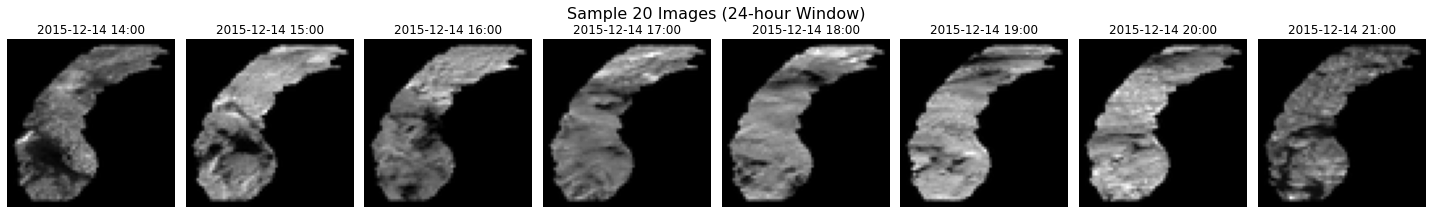

In [61]:
# Display the first 20 samples for the 24-hour window
display_first_n_samples(reduced_data_filtered_all, window_size=24, num_samples=20)

# 6. Model Building

Finally, Let's get to the most interesting part of this notebook, building our very own model with an RNN-based architecture. And we can go about it using a couple of different approaches. Instead of choosing one of them, why don't we try all of them and see which one is doing helps predict rainfall wiht grater accuracy. Shall we begin then?

## 6.1. Expermient - 1, Building Individual Models using Downsampling

When we think of building models for different sliding windows, our first thought would be to build an Individual model for each sliding window. So, why don't we start wiht that? Let's start with trying to build an Individual Model, for each sliding window, and check out how the model performs.

Our dataset is super imbalanced. This means one class has way more data points than the other(s). Just for example, if we look at the class distribution among our 24-sliding window dataset below:

Class distribution in Train Set:
  Class 0: 422 (1.35%)
  Class 1: 1029 (3.29%)
  Class 2: 783 (2.51%)
  Class 3: 29019 (92.85%)

And that's bad because our models will just learn to predict the majority class all the time, totally ignoring the minority class.

To fix this, we’ve got two main options: <b>oversampling</b> or <b>downsampling</b>.

<b>What’s oversampling?</b>

Oversampling means we create more data for the minority class. We can duplicate existing data points or even generate synthetic ones (like using SMOTE). It’s like padding your notes before an exam—you just add extra stuff to balance things out.
What’s downsampling?

<b>What's downsampling?</b>

Downsampling is the opposite. Here, we reduce the data points in the majority class to match the minority class. Think of it as trimming the excess to make things equal.

<b>Why not oversample time series data?</b>

For time series data, oversampling is tricky. Time series relies on the order of data, so just duplicating or generating points can mess up the sequence and correlations. It’s like trying to copy a diary entry for a future date—it just doesn’t work the same way.

<b>So, let’s downsample!</b>

For time series, downsampling is safer. We’ll remove some points from the majority class, keeping the order and sequence intact. Sure, we lose some data, but it’s worth it if it helps the model generalize better. 

### 6.1.1 Downsampling

Now, let’s balance things out! We'll use the code below to downsample the majority classes so every class has the same number of samples, making sure our models learns fairly from all classes.

In [ ]:
from sklearn.utils import resample

def downsample_to_minority(X, y):
    """
    Downsample the majority classes to match the size of the minority class.
    
    Args:
        X (np.ndarray): Input features (e.g., meteorological data).
        y (np.ndarray): Labels (one-hot encoded or class indices).
        
    Returns:
        X_downsampled (np.ndarray): Downsampled features.
        y_downsampled (np.ndarray): Downsampled labels.
    """
    # Convert one-hot encoded labels to class indices if needed
    if len(y.shape) > 1 and y.shape[1] > 1:
        y_classes = np.argmax(y, axis=1)
    else:
        y_classes = y

    # Find the minimum class count
    unique_classes, class_counts = np.unique(y_classes, return_counts=True)
    min_class_count = np.min(class_counts)
    print(f"Class counts before downsampling: {dict(zip(unique_classes, class_counts))}")
    print(f"Downsampling to {min_class_count} samples per class.")

    # Downsample each class
    X_downsampled = []
    y_downsampled = []
    for cls in unique_classes:
        cls_indices = np.where(y_classes == cls)[0]
        cls_X = X[cls_indices]
        cls_y = y[cls_indices]

        # Downsample the class to match the minority count
        cls_X_downsampled, cls_y_downsampled = resample(
            cls_X, cls_y,
            replace=False,  # No replacement
            n_samples=min_class_count,
            random_state=42  # For reproducibility
        )
        X_downsampled.append(cls_X_downsampled)
        y_downsampled.append(cls_y_downsampled)

    # Concatenate all downsampled data
    X_downsampled = np.vstack(X_downsampled)
    y_downsampled = np.vstack(y_downsampled) if len(y.shape) > 1 else np.hstack(y_downsampled)

    # Shuffle the data to mix classes
    indices = np.arange(len(X_downsampled))
    np.random.shuffle(indices)
    X_downsampled = X_downsampled[indices]
    y_downsampled = y_downsampled[indices]

    print(f"Class counts after downsampling: {np.unique(y_downsampled, return_counts=True)}")
    return X_downsampled, y_downsampled

### 6.1.2 24-Hour Window Model with Downsampling

<b>Model Architecture</b>

Now, let’s dive into building an exciting model for the 24-hour window prediction. Here’s how we structure it:
- <b>Input Layer:</b> The model takes a single input corresponding to the 24-hour window with 10 features per timestep.
- <b>Architecture:</b>
    - A Bidirectional LSTM is used to capture patterns in the time-series data from both past and future contexts, ensuring robust temporal understanding.
    - Batch Normalization stabilizes training, and Dropout prevents overfitting by adding regularization.
    - A Residual Connection preserves key information and improves gradient flow, enhancing training efficiency.
    - An Attention Mechanism ensures the model focuses on the most relevant parts of the sequence, dynamically highlighting critical features.
    - Global Average Pooling and Global Max Pooling compactly summarize the attention-augmented features into fixed-size representations, which are then concatenated for rich feature extraction.

- <b>Output Layer:</b> A task-specific dense layer with a softmax activation outputs the class probabilities for the 24-hour window.

This model is designed to deliver precise predictions while effectively managing time-series complexities using advanced mechanisms like attention and residuals.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Attention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Add
from tensorflow.keras.optimizers import Adam

# Define the RNN model structure for the 24-hour window
def rnn_model_24_window(num_classes):
    # Define input for the 24-hour window
    input_24 = Input(shape=(24, 10), name="input_24")

    # Shared feature extractor
    def feature_extractor(input_layer):
        x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        residual = x

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)

        # Residual connection
        x = Add()([x, Dense(128)(residual)])

        # Attention mechanism
        attention = Attention()([x, x])
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)

        return Concatenate()([avg_pool, max_pool])

    # Feature extraction for the 24-hour input
    features_24 = feature_extractor(input_24)

    # Task-specific output
    output_24 = Dense(num_classes, activation='softmax', name="output_24")(features_24)

    # Define the model
    model = Model(inputs=input_24, outputs=output_24)
    
    return model

# Build the model for the 24-hour window
num_classes = reduced_data_filtered_all[24]['y_train'].shape[1]
model_24 = rnn_model_24_window(num_classes)

# Compile the model outside the function
model_24.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model_24.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_24            │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 256)   │    142,336 │ input_24[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 128)   │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 128)   │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 128)   │          0 │ add[0][0],        │
│ (Attention)         │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_24 (Dense)   │ (None, 4)         │      1,028 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,148 (1.31 MB)

 Trainable params: 341,380 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

<b>ReduceLROnPlateau</b>: We will be using the ReduceLROnPlateau callback to dynamically adjust the learning rate while training our model. We will monitor the validation loss during each epoch, and if it stops improving for five consecutive epochs, we will reduce the learning rate by half. 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor the validation loss
    factor=0.5,         # Reduce the learning rate by half
    patience=5,         # Number of epochs to wait before reducing
    min_lr=1e-6,        # Minimum learning rate
    verbose=1
)

In [ ]:
# Verify the reduced data shapes
print(f"Reduced 24-hour Training: {reduced_data_filtered_all[24]['X_train_meteo'].shape}")
print(f"Reduced 24-hour Validation: {reduced_data_filtered_all[24]['X_val_meteo'].shape}")
print(f"Reduced 48-hour Training: {reduced_data_filtered_all[48]['X_train_meteo'].shape}")
print(f"Reduced 48-hour Validation: {reduced_data_filtered_all[48]['X_val_meteo'].shape}")
print(f"Reduced 72-hour Training: {reduced_data_filtered_all[72]['X_train_meteo'].shape}")
print(f"Reduced 72-hour Validation: {reduced_data_filtered_all[72]['X_val_meteo'].shape}")

Reduced 24-hour Training: (31253, 24, 10)
Reduced 24-hour Validation: (504, 24, 10)
Reduced 48-hour Training: (31196, 48, 10)
Reduced 48-hour Validation: (504, 48, 10)
Reduced 72-hour Training: (31138, 72, 10)
Reduced 72-hour Validation: (504, 72, 10)


In [ ]:
X_train_24, y_train_24 = reduced_data_filtered_all[24]['X_train_meteo'], reduced_data_filtered_all[24]['y_train']
X_val_24, y_val_24 = reduced_data_filtered_all[24]['X_val_meteo'], reduced_data_filtered_all[24]['y_val']


# Downsample training data for the 24-hour window
X_train_24_downsampled, y_train_24_downsampled = downsample_to_minority(
    X_train_24, 
    y_train_24
)

# Verify class distribution after downsampling
print("Class distribution after downsampling for 24-hour window:")
unique, counts = np.unique(np.argmax(y_train_24_downsampled, axis=1), return_counts=True)
print(dict(zip(unique, counts)))


# Extract image data
X_train_images_24 = reduced_data_filtered_all[24]['X_train_images']
X_val_images_24 = reduced_data_filtered_all[24]['X_val_images']

X_train_48, y_train_48 = reduced_data_filtered_all[48]['X_train_meteo'], reduced_data_filtered_all[48]['y_train']
X_val_48, y_val_48 = reduced_data_filtered_all[48]['X_val_meteo'], reduced_data_filtered_all[48]['y_val']
X_train_images_48 = reduced_data_filtered_all[48]['X_train_images']
X_val_images_48 = reduced_data_filtered_all[48]['X_val_images']

X_train_72, y_train_72 = reduced_data_filtered_all[72]['X_train_meteo'], reduced_data_filtered_all[72]['y_train']
X_val_72, y_val_72 = reduced_data_filtered_all[72]['X_val_meteo'], reduced_data_filtered_all[72]['y_val']
X_train_images_72 = reduced_data_filtered_all[72]['X_train_images']
X_val_images_72 = reduced_data_filtered_all[72]['X_val_images']

Class counts before downsampling: {np.int64(0): np.int64(422), np.int64(1): np.int64(1029), np.int64(2): np.int64(783), np.int64(3): np.int64(29019)}
Downsampling to 422 samples per class.
Class counts after downsampling: (array([0., 1.]), array([5064, 1688]))
Class distribution after downsampling for 24-hour window:
{np.int64(0): np.int64(422), np.int64(1): np.int64(422), np.int64(2): np.int64(422), np.int64(3): np.int64(422)}


We were able to tackle the initial imbalance in the dataset for the 24-hour window, where some classes had way more samples than others. After processing, we successfully brought all the classes down to an equal size of 422 samples each. This ensures our model won’t favor any particular class and gives it a fair shot at learning patterns across all categories. Now, the class distribution looks balanced and ready for effective training!

<b>Training</b>

Why don't we start training then, let's go for a 100 epochs and see how it is going.

In [ ]:
history = model_24.fit(
    x={"input_24": X_train_24_downsampled},
    y=y_train_24_downsampled,  # Pass y as an array, not a dictionary
    validation_data=(
        {"input_24": X_val_24},
        y_val_24  # Similarly, pass validation y as an array
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.2801 - loss: 1.9197 - val_accuracy: 0.2579 - val_loss: 1.4636 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3134 - loss: 1.5695 - val_accuracy: 0.2659 - val_loss: 1.4785 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3346 - loss: 1.5550 - val_accuracy: 0.2798 - val_loss: 1.3975 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3485 - loss: 1.4447 - val_accuracy: 0.2659 - val_loss: 1.4994 - learning_rate: 0.0010
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3701 - loss: 1.3949 - val_accuracy: 0.3036 - val_loss: 1.4304 - learning_rate: 0.0010
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4025 - loss: 1.3043 - val_accuracy: 0.3313 - val_loss: 1.4192 - learning_rate: 0.0010
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3891 - loss: 1.3423 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Classification Report for 24-hour Output:
              precision    recall  f1-score   support

           0       0.38      0.48      0.42       126
           1       0.31      0.27      0.29       126
           2       0.26      0.28      0.27       126
           3       0.43      0.34      0.38       126

    accuracy                           0.34       504
   macro avg       0.35      0.34      0.34       504
weighted avg       0.35      0.34      0.34       504



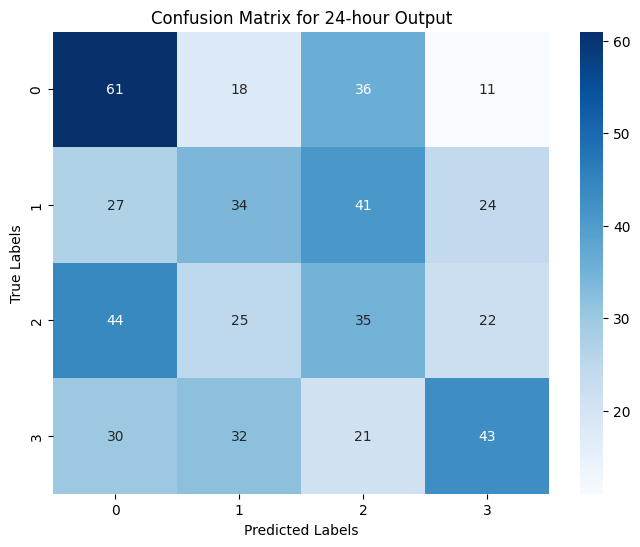

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Predict on the validation data
val_predictions_model_24 = model_24.predict({
    "input_24": X_val_24,
})

# Convert predictions to class indices
predicted_classes_24 = np.argmax(val_predictions_model_24, axis=1)  # For 24-hour output

# Convert true labels to class indices
true_classes_24 = np.argmax(y_val_24, axis=1)  # For 24-hour output

print("Classification Report for 24-hour Output:")
print(classification_report(true_classes_24, predicted_classes_24))
plot_confusion_matrix(true_classes_24, predicted_classes_24, "Confusion Matrix for 24-hour Output")


Our model’s performance is definitely not where we want it to be right now and could use some serious fine-tuning. Here’s how it’s doing so far: an accuracy of just <b>34%</b>, precision ranging between <b>26%</b> and <b>43%</b>, and F1-scores that top out at <b>0.42</b> for Class 0</b> but drop as low as <b>0.27 for Class 2</b>. Clearly, the model is struggling to distinguish some classes, and there’s plenty of room for improvement!

In [ ]:
# Save the model after training
model_24.save("downsampled_model_24.h5")
print("Model saved successfully as 'downsampled_model_24.h5'")


Model saved successfully as 'downsampled_model_24.h5'


### 6.1.3 48-Hour Window Model

Let's do a similar process for out 48-Hour Window Model as well.

In [ ]:
# Define the RNN model structure for the 48-hour window
def rnn_model_48_window(num_classes):
    # Define input for the 24-hour window
    input_48 = Input(shape=(48, 10), name="input_48")

    # Shared feature extractor
    def feature_extractor(input_layer):
        x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        residual = x

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)

        # Residual connection
        x = Add()([x, Dense(128)(residual)])

        # Attention mechanism
        attention = Attention()([x, x])
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)

        return Concatenate()([avg_pool, max_pool])

    # Feature extraction for the 24-hour input
    features_48 = feature_extractor(input_48)

    # Task-specific output
    output_48 = Dense(num_classes, activation='softmax', name="output_48")(features_48)

    # Define the model
    model = Model(inputs=input_48, outputs=output_48)
    
    return model

# Build the model for the 48-hour window
num_classes = reduced_data_filtered_all[48]['y_train'].shape[1]
model_48 = rnn_model_48_window(num_classes)

# Compile the model outside the function
model_48.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model_48.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_48            │ (None, 48, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 48, 256)   │    142,336 │ input_48[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 256)   │      1,024 │ bidirectional_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 48, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 48, 128)   │    164,352 │ dropout_4[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 128)   │        512 │ bidirectional_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 48, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 48, 128)   │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 48, 128)   │          0 │ dropout_5[0][0],  │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 48, 128)   │          0 │ add_2[0][0],      │
│ (Attention)         │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_2[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_48 (Dense)   │ (None, 4)         │      1,028 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,148 (1.31 MB)

 Trainable params: 341,380 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:

# Downsample training data for the 48-hour window
X_train_48_downsampled, y_train_48_downsampled = downsample_to_minority(
    X_train_48, 
    y_train_48
)

# Verify class distribution after downsampling
print("Class distribution after downsampling for 48-hour window:")
unique, counts = np.unique(np.argmax(y_train_48_downsampled, axis=1), return_counts=True)
print(dict(zip(unique, counts)))

Class counts before downsampling: {np.int64(0): np.int64(421), np.int64(1): np.int64(1027), np.int64(2): np.int64(783), np.int64(3): np.int64(28965)}
Downsampling to 421 samples per class.
Class counts after downsampling: (array([0., 1.]), array([5052, 1684]))
Class distribution after downsampling for 48-hour window:
{np.int64(0): np.int64(421), np.int64(1): np.int64(421), np.int64(2): np.int64(421), np.int64(3): np.int64(421)}


In [ ]:
history = model_48.fit(
    x={"input_48": X_train_48_downsampled},
    y= y_train_48_downsampled,  # Pass y as an array, not a dictionary
    validation_data=(
        {"input_48": X_val_48},
        y_val_48  # Similarly, pass validation y as an array
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.2622 - loss: 2.0954 - val_accuracy: 0.2679 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3035 - loss: 1.5420 - val_accuracy: 0.2758 - val_loss: 1.4217 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3237 - loss: 1.5250 - val_accuracy: 0.2778 - val_loss: 1.4556 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3446 - loss: 1.4595 - val_accuracy: 0.2917 - val_loss: 1.4765 - learning_rate: 0.0010
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3616 - loss: 1.4121 - val_accuracy: 0.3214 - val_loss: 1.4259 - learning_rate: 0.0010
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3736 - loss: 1.3735 - val_accuracy: 0.3175 - val_loss: 1.5053 - learning_rate: 0.0010
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3857 - loss: 1.3350
Ep

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Classification Report for 48-hour Output:
              precision    recall  f1-score   support

           0       0.41      0.58      0.48       126
           1       0.32      0.37      0.34       126
           2       0.35      0.19      0.25       126
           3       0.38      0.36      0.37       126

    accuracy                           0.37       504
   macro avg       0.37      0.37      0.36       504
weighted avg       0.37      0.37      0.36       504



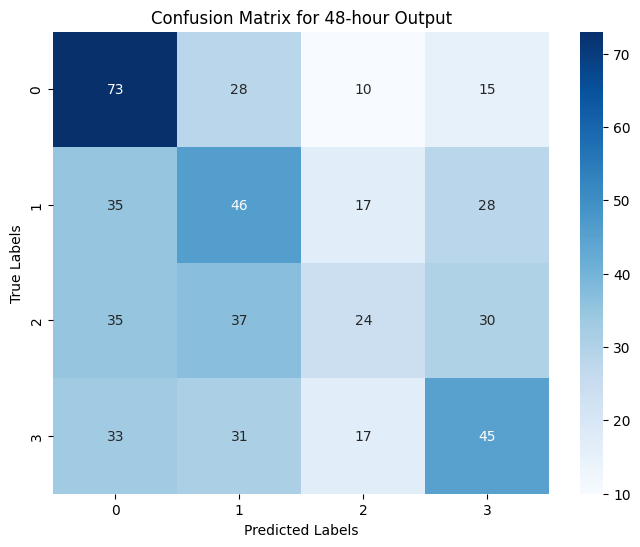

In [ ]:
# Predict on the validation data
val_predictions_model_48 = model_48.predict({
    "input_48": X_val_48,
})

# Convert predictions to class indices
predicted_classes_48 = np.argmax(val_predictions_model_48, axis=1)  # For 48-hour output

# Convert true labels to class indices
true_classes_48 = np.argmax(y_val_48, axis=1)  # For 48-hour output

print("Classification Report for 48-hour Output:")
print(classification_report(true_classes_48, predicted_classes_48))
plot_confusion_matrix(true_classes_48, predicted_classes_48, "Confusion Matrix for 48-hour Output")

Our model for the 48-hour rainfall prediction is doing slightly better but still has a long way to go. So far, we’re seeing an accuracy of <b>37%</b>, with precision ranging from <b>32%</b> to <b>41%</b>, and F1-scores that peak at <b>0.48 for Class 0</b> but dip as low as <b>0.25 for Class 2</b>. While Class 0 predictions are looking somewhat decent, the model is clearly struggling to handle the other classes, especially Class 2. There’s progress, but there’s still plenty of work to do!

In [ ]:
# Save the model after training
model_48.save("downsampled_model_48.h5")
print("Model saved successfully as 'downsampled_model_48.h5'")

Model saved successfully as 'downsampled_model_48.h5'


### 6.1.4 72-Hour Window Model

Let's do follow a similar procedure for the 72-Hour Window Model

In [ ]:
# Define the RNN model structure for the 72-hour window
def rnn_model_72_window(num_classes):
    # Define input for the 24-hour window
    input_72 = Input(shape=(72, 10), name="input_72")

    # Shared feature extractor
    def feature_extractor(input_layer):
        x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        residual = x

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)

        # Residual connection
        x = Add()([x, Dense(128)(residual)])

        # Attention mechanism
        attention = Attention()([x, x])
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)

        return Concatenate()([avg_pool, max_pool])

    # Feature extraction for the 24-hour input
    features_72 = feature_extractor(input_72)

    # Task-specific output
    output_72 = Dense(num_classes, activation='softmax', name="output_72")(features_72)

    # Define the model
    model = Model(inputs=input_72, outputs=output_72)
    
    return model

# Build the model for the 72-hour window
num_classes = reduced_data_filtered_all[72]['y_train'].shape[1]
model_72 = rnn_model_72_window(num_classes)

# Compile the model outside the function
model_72.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model_72.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_72            │ (None, 72, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 72, 256)   │    142,336 │ input_72[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 256)   │      1,024 │ bidirectional_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 72, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 72, 128)   │    164,352 │ dropout_6[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 128)   │        512 │ bidirectional_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 72, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 72, 128)   │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 72, 128)   │          0 │ dropout_7[0][0],  │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 72, 128)   │          0 │ add_3[0][0],      │
│ (Attention)         │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_3[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_3[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_72 (Dense)   │ (None, 4)         │      1,028 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,148 (1.31 MB)

 Trainable params: 341,380 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Downsample training data for the 72-hour window
X_train_72_downsampled, y_train_72_downsampled = downsample_to_minority(
    X_train_72, 
    y_train_72
)

# Verify class distribution after downsampling
print("Class distribution after downsampling for 72-hour window:")
unique, counts = np.unique(np.argmax(y_train_72_downsampled, axis=1), return_counts=True)
print(dict(zip(unique, counts)))

Class counts before downsampling: {np.int64(0): np.int64(416), np.int64(1): np.int64(1024), np.int64(2): np.int64(780), np.int64(3): np.int64(28918)}
Downsampling to 416 samples per class.
Class counts after downsampling: (array([0., 1.]), array([4992, 1664]))
Class distribution after downsampling for 72-hour window:
{np.int64(0): np.int64(416), np.int64(1): np.int64(416), np.int64(2): np.int64(416), np.int64(3): np.int64(416)}


In [ ]:
history = model_72.fit(
    x={"input_72": X_train_72_downsampled},
    y=y_train_72_downsampled,  # Pass y as an array, not a dictionary
    validation_data=(
        {"input_72": X_val_72},
        y_val_72  # Similarly, pass validation y as an array
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.2692 - loss: 2.5293 - val_accuracy: 0.2956 - val_loss: 1.4204 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3091 - loss: 1.5250 - val_accuracy: 0.2976 - val_loss: 1.4098 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3689 - loss: 1.4126 - val_accuracy: 0.2996 - val_loss: 1.4012 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3750 - loss: 1.3500 - val_accuracy: 0.2877 - val_loss: 1.4895 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3883 - loss: 1.3640 - val_accuracy: 0.2698 - val_loss: 1.4738 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3998 - loss: 1.3185 - val_accuracy: 0.3115 - val_loss: 1.3922 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4078 - loss: 1.3343 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Classification Report for 72-hour Output:
              precision    recall  f1-score   support

           0       0.46      0.56      0.50       126
           1       0.31      0.37      0.34       126
           2       0.33      0.29      0.31       126
           3       0.48      0.33      0.39       126

    accuracy                           0.39       504
   macro avg       0.39      0.39      0.38       504
weighted avg       0.39      0.39      0.38       504



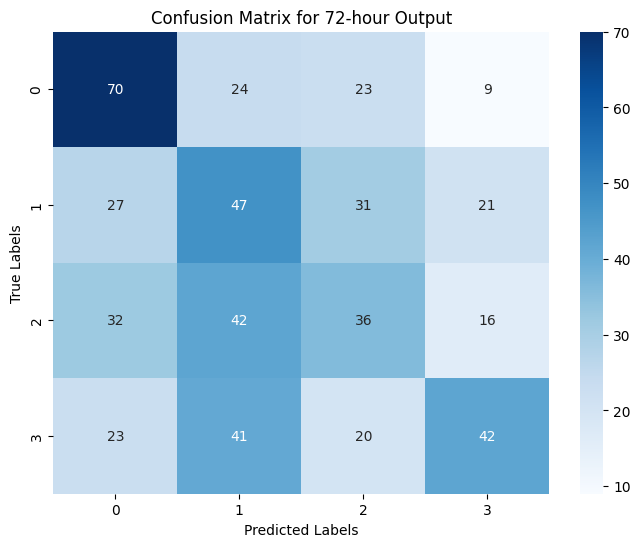

In [ ]:
# Predict on the validation data
val_predictions_model_72 = model_72.predict({
    "input_72": X_val_72,
})

# Convert predictions to class indices
predicted_classes_72 = np.argmax(val_predictions_model_72, axis=1)  # For 72-hour output

# Convert true labels to class indices
true_classes_72 = np.argmax(y_val_72, axis=1)  # For 72-hour output

print("Classification Report for 72-hour Output:")
print(classification_report(true_classes_72, predicted_classes_72))
plot_confusion_matrix(true_classes_72, predicted_classes_72, "Confusion Matrix for 72-hour Output")

Our model for the 72-hour rainfall prediction is showing slight improvements but still struggles in key areas. Here’s how it’s performing so far: an accuracy of 39%, precision ranging from 31% to 48%, and F1-scores peaking at 0.50 for Class 0 but dipping as low as 0.31 for Class 2. Class 0 predictions are decent, but the model continues to have difficulty distinguishing other classes, especially Class 2. While there’s progress compared to shorter windows, there’s still significant room for optimization!

In [ ]:
# Save the model after training
model_72.save("downsampled_model_72.h5")
print("Model saved successfully as 'downsampled_model_72.h5'")

Model saved successfully as 'downsampled_model_72.h5'


### 6.1.5 Downsmapling Conclusion

<b>What do the classification reports from our models tell us?</b>

The reports highlight a key challenge with our approach: while downsampling helped address the severe class imbalance in our dataset, it also led to a significant reduction in data. For example, in the 24-hour window, Class 3 originally had 29,019 samples, but after downsampling, all classes were reduced to just 422 samples. This balancing act has ensured fair training but left the model with limited data to learn and generalize effectively.

This is evident in the metrics—accuracy ranges from 34% in the 24-hour model to 39% in the 72-hour model, with precision and recall varying widely between 26% and 48%. The model is struggling to generalize, particularly with underrepresented patterns in rainfall prediction.

While downsampling helps create a balanced training set, the loss of data is holding the model back. To improve, we'll try to use class weights to give the model the depth it needs to generalize better.

## 6.2 Experiment-2, Individual Models using Class Weights

Let’s try experimenting with class weights now and see if we can strike a better balance. By assigning weights to each class based on their representation in the dataset, we can address the imbalance without having to downsample so drastically. This way, instead of reducing the data and potentially starving the model of enough examples to train properly, we’ll let the model learn from all available data while emphasizing underrepresented classes during training. This approach might just help us preserve more of the dataset’s richness and improve the model’s ability to generalize effectively.

### 6.2.1 Adjusting Class Weights

Our dataset is highly biased, in every single window, out of the four classes that we have (No Rain, Little Rain, Medium Rain, and Heavy Rain), the dataset is heavily biased towards No Rain. And in order to do that, we'll use a concept called class weights.

<b>What are class weights?</b>
Class weights are a technique used in machine learning to address class imbalance in datasets. When some classes are underrepresented compared to others, a model may become biased towards the majority class. Class weights assign different importance (or weights) to each class during training, ensuring the model pays more attention to minority classes.

- Class Weight Calculation:
    - For each window size, we compute the class weights using compute_class_weight from sklearn.
    - The class_weight='balanced' option ensures that weights are inversely proportional to the class frequency, so minority classes are given higher weights.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf


# Compute class weights for the 24-hour window (after filtering and reduction)
class_weights_filtered_24 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(reduced_data_filtered_all[24]['y_train'], axis=1)),
    y=np.argmax(reduced_data_filtered_all[24]['y_train'], axis=1)
)

# Compute class weights for the 48-hour window (after filtering and reduction)
class_weights_filtered_48 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(reduced_data_filtered_all[48]['y_train'], axis=1)),
    y=np.argmax(reduced_data_filtered_all[48]['y_train'], axis=1)
)

# Compute class weights for the 72-hour window (after filtering and reduction)
class_weights_filtered_72 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(reduced_data_filtered_all[72]['y_train'], axis=1)),
    y=np.argmax(reduced_data_filtered_all[72]['y_train'], axis=1)
)

# Store all class weights in a dictionary
class_weights_dict = {
    24: class_weights_filtered_24,
    48: class_weights_filtered_48,
    72: class_weights_filtered_72
}


class_weights_dict

{24: array([18.51481043,  7.59305151,  9.97860792,  0.26924601]),
 48: array([18.52494062,  7.593963  ,  9.96040868,  0.269256  ]),
 72: array([18.71274038,  7.60205078,  9.98012821,  0.2691922 ])}

We'll define a custom weighted loss functions for handling class imbalance during the training of a machine learning model. The focus is on adjusting the standard categorical cross-entropy loss using class weights.

In [ ]:
# Define custom weighted loss functions for each output
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Ensure no new variables are created
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return unweighted_loss * weights
    return loss

class_weights_24_tensor = tf.constant(class_weights_filtered_24, dtype=tf.float32)
class_weights_48_tensor = tf.constant(class_weights_filtered_48, dtype=tf.float32)
class_weights_72_tensor = tf.constant(class_weights_filtered_72, dtype=tf.float32)

### 6.2.2 24-Hour Window Model with Class Weights

Now, let's define a similar model from above, and check the results of how the model is performing:

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Attention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Add
from tensorflow.keras.optimizers import Adam

# Define the RNN model structure for the 24-hour window
def rnn_model_24_window(num_classes):
    # Define input for the 24-hour window
    input_24 = Input(shape=(24, 10), name="input_24")

    # Shared feature extractor
    def feature_extractor(input_layer):
        x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        residual = x

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)

        # Residual connection
        x = Add()([x, Dense(128)(residual)])

        # Attention mechanism
        attention = Attention()([x, x])
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)

        return Concatenate()([avg_pool, max_pool])

    # Feature extraction for the 24-hour input
    features_24 = feature_extractor(input_24)

    # Task-specific output
    output_24 = Dense(num_classes, activation='softmax', name="output_24")(features_24)

    # Define the model
    model = Model(inputs=input_24, outputs=output_24)
    
    return model

# Build the model for the 24-hour window
num_classes = reduced_data_filtered_all[24]['y_train'].shape[1]
model_24 = rnn_model_24_window(num_classes)

# Compile the model outside the function
model_24.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model_24.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_24            │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 256)   │    142,336 │ input_24[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 128)   │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 128)   │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 128)   │          0 │ add[0][0],        │
│ (Attention)         │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_24 (Dense)   │ (None, 4)         │      1,028 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,148 (1.31 MB)

 Trainable params: 341,380 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor the validation loss
    factor=0.5,         # Reduce the learning rate by half
    patience=5,         # Number of epochs to wait before reducing
    min_lr=1e-6,        # Minimum learning rate
    verbose=1
)

In [ ]:
# Verify the reduced data shapes
print(f"Reduced 24-hour Training: {reduced_data_filtered_all[24]['X_train_meteo'].shape}")
print(f"Reduced 24-hour Validation: {reduced_data_filtered_all[24]['X_val_meteo'].shape}")
print(f"Reduced 48-hour Training: {reduced_data_filtered_all[48]['X_train_meteo'].shape}")
print(f"Reduced 48-hour Validation: {reduced_data_filtered_all[48]['X_val_meteo'].shape}")
print(f"Reduced 72-hour Training: {reduced_data_filtered_all[72]['X_train_meteo'].shape}")
print(f"Reduced 72-hour Validation: {reduced_data_filtered_all[72]['X_val_meteo'].shape}")

Reduced 24-hour Training: (31253, 24, 10)
Reduced 24-hour Validation: (504, 24, 10)
Reduced 48-hour Training: (31196, 48, 10)
Reduced 48-hour Validation: (504, 48, 10)
Reduced 72-hour Training: (31138, 72, 10)
Reduced 72-hour Validation: (504, 72, 10)


In [ ]:
X_train_24, y_train_24 = reduced_data_filtered_all[24]['X_train_meteo'], reduced_data_filtered_all[24]['y_train']
X_val_24, y_val_24 = reduced_data_filtered_all[24]['X_val_meteo'], reduced_data_filtered_all[24]['y_val']
# Extract image data
X_train_images_24 = reduced_data_filtered_all[24]['X_train_images']
X_val_images_24 = reduced_data_filtered_all[24]['X_val_images']

X_train_48, y_train_48 = reduced_data_filtered_all[48]['X_train_meteo'], reduced_data_filtered_all[48]['y_train']
X_val_48, y_val_48 = reduced_data_filtered_all[48]['X_val_meteo'], reduced_data_filtered_all[48]['y_val']
X_train_images_48 = reduced_data_filtered_all[48]['X_train_images']
X_val_images_48 = reduced_data_filtered_all[48]['X_val_images']

X_train_72, y_train_72 = reduced_data_filtered_all[72]['X_train_meteo'], reduced_data_filtered_all[72]['y_train']
X_val_72, y_val_72 = reduced_data_filtered_all[72]['X_val_meteo'], reduced_data_filtered_all[72]['y_val']
X_train_images_72 = reduced_data_filtered_all[72]['X_train_images']
X_val_images_72 = reduced_data_filtered_all[72]['X_val_images']

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot encoded labels to integer labels
y_train_24_int = np.argmax(reduced_data_filtered_all[24]['y_train'], axis=1)

# Get the unique classes
classes = np.unique(y_train_24_int)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_24_int
)

# Convert the class weights array to a dictionary
class_weights_filtered_24 = dict(zip(classes, class_weights_array))
class_weights_filtered_24

{np.int64(0): np.float64(18.514810426540283),
 np.int64(1): np.float64(7.5930515063168125),
 np.int64(2): np.float64(9.97860791826309),
 np.int64(3): np.float64(0.2692460112340191)}

In [ ]:
history = model_24.fit(
    x={"input_24": X_train_24},
    y=y_train_24,  # Pass y as an array, not a dictionary
    validation_data=(
        {"input_24": X_val_24},
        y_val_24  # Similarly, pass validation y as an array
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr],
    class_weight=class_weights_filtered_24,
    verbose=1
)

Epoch 1/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 65s 53ms/step - accuracy: 0.2798 - loss: 1.8974 - val_accuracy: 0.3115 - val_loss: 1.4665 - learning_rate: 0.0010
Epoch 2/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 49s 50ms/step - accuracy: 0.3090 - loss: 1.5027 - val_accuracy: 0.2837 - val_loss: 1.4821 - learning_rate: 0.0010
Epoch 3/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.3289 - loss: 1.4399 - val_accuracy: 0.2976 - val_loss: 1.4286 - learning_rate: 0.0010
Epoch 4/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.3105 - loss: 1.4774 - val_accuracy: 0.3829 - val_loss: 1.3728 - learning_rate: 0.0010
Epoch 5/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.2997 - loss: 1.4617 - val_accuracy: 0.3214 - val_loss: 1.3851 - learning_rate: 0.0010
Epoch 6/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.3235 - loss: 1.4263 - val_accuracy: 0.3135 - val_loss: 1.4044 - learning_rate: 0.0010
Epoch 7/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.3

The following function helps us build a classification report on every model in this notebook.

The classification reports summarize the model's performance across four precipitation categories (0, 1, 2, 3), which likely correspond to "No Rain," "Less Rain," "Medium Rain," and "High Rain." Key metrics:
- <b>Precision:</b> How many of the predicted values for a class were correct.
- <b>Recall:</b> How many actual instances of a class were correctly predicted.
- <b>F1-score:</b> The harmonic mean of precision and recall, providing a single measure of model performance.
- <b>Support:</b> The number of true instances for each class.

So, what are those colorful boxes? These are what we call Confusion Matrix.

<b>What are Confusion Matrices?</b>
    
Each matrix represents the model's prediction results compared to actual labels:
- Rows correspond to true classes.
- Columns correspond to predicted classes.
- The diagonal indicates correct predictions.
- Off-diagonal elements represent misclassifications.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Classification Report for 24-hour Output:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       126
           1       0.32      0.25      0.28       126
           2       0.39      0.30      0.34       126
           3       0.46      0.67      0.55       126

    accuracy                           0.44       504
   macro avg       0.42      0.44      0.42       504
weighted avg       0.42      0.44      0.42       504



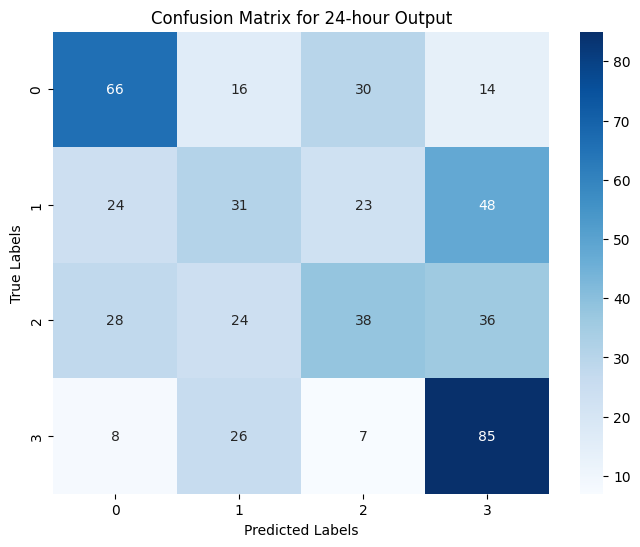

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Predict on the validation data
val_predictions_model_24 = model_24.predict({
    "input_24": X_val_24,
})

# Convert predictions to class indices
predicted_classes_24 = np.argmax(val_predictions_model_24, axis=1)  # For 24-hour output

# Convert true labels to class indices
true_classes_24 = np.argmax(y_val_24, axis=1)  # For 24-hour output

print("Classification Report for 24-hour Output:")
print(classification_report(true_classes_24, predicted_classes_24))
plot_confusion_matrix(true_classes_24, predicted_classes_24, "Confusion Matrix for 24-hour Output")


The model with class weights for the 24-hour window is performing noticeably better than the downsampled version:
- **Accuracy**: Jumped to **44%** (up from 34% in the downsampled version).
- **F1-Scores**:
  - Class 3 improved significantly to **0.55**.
  - Class 2 saw a slight increase to **0.34**.
  - Class 1 still struggles at **0.28**.
- **Macro Averages**: Precision, recall, and F1-score improved to around **0.42–0.44**, showing clear progress.

The confusion matrix also looks healthier:
- **85 correct predictions** for Class 3 (compared to 61 earlier).
- More balanced representation across all classes.

Overall, using class weights helped the model generalize better without losing valuable data!



In [ ]:
# Save the model after training
model_24.save("model_24.h5")
print("Model saved successfully as 'model_24.h5'")


Model saved successfully as 'model_24.h5'


### 6.2.3 48-Hour Window Model with Class Weights

In [ ]:
# Define the RNN model structure for the 48-hour window
def rnn_model_48_window(num_classes):
    # Define input for the 24-hour window
    input_48 = Input(shape=(48, 10), name="input_48")

    # Shared feature extractor
    def feature_extractor(input_layer):
        x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        residual = x

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)

        # Residual connection
        x = Add()([x, Dense(128)(residual)])

        # Attention mechanism
        attention = Attention()([x, x])
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)

        return Concatenate()([avg_pool, max_pool])

    # Feature extraction for the 24-hour input
    features_48 = feature_extractor(input_48)

    # Task-specific output
    output_48 = Dense(num_classes, activation='softmax', name="output_48")(features_48)

    # Define the model
    model = Model(inputs=input_48, outputs=output_48)
    
    return model

# Build the model for the 48-hour window
num_classes = reduced_data_filtered_all[48]['y_train'].shape[1]
model_48 = rnn_model_48_window(num_classes)

# Compile the model outside the function
model_48.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model_48.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_48            │ (None, 48, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 48, 256)   │    142,336 │ input_48[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 48, 128)   │    164,352 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 128)   │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 48, 128)   │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 128)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 48, 128)   │          0 │ add_1[0][0],      │
│ (Attention)         │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_48 (Dense)   │ (None, 4)         │      1,028 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,148 (1.31 MB)

 Trainable params: 341,380 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Convert one-hot encoded labels to integer labels
y_train_48_int = np.argmax(reduced_data_filtered_all[48]['y_train'], axis=1)

# Get the unique classes
classes = np.unique(y_train_48_int)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_48_int
)

# Convert the class weights array to a dictionary
class_weights_filtered_48 = dict(zip(classes, class_weights_array))
class_weights_filtered_48

{np.int64(0): np.float64(18.524940617577197),
 np.int64(1): np.float64(7.5939629990262905),
 np.int64(2): np.float64(9.960408684546616),
 np.int64(3): np.float64(0.26925599861902294)}

In [ ]:
history = model_48.fit(
    x={"input_48": X_train_48},
    y=y_train_48,  # Pass y as an array, not a dictionary
    validation_data=(
        {"input_48": X_val_48},
        y_val_48  # Similarly, pass validation y as an array
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr],
    class_weight=class_weights_filtered_48,
    verbose=1
)

Epoch 1/100
975/975 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.2693 - loss: 1.9491 - val_accuracy: 0.2460 - val_loss: 1.8953 - learning_rate: 0.0010
Epoch 2/100
975/975 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.2813 - loss: 1.6283 - val_accuracy: 0.3452 - val_loss: 1.5048 - learning_rate: 0.0010
Epoch 3/100
975/975 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.3156 - loss: 1.4431 - val_accuracy: 0.3036 - val_loss: 1.3935 - learning_rate: 0.0010
Epoch 4/100
975/975 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.2754 - loss: 1.4668 - val_accuracy: 0.2758 - val_loss: 1.4642 - learning_rate: 0.0010
Epoch 5/100
975/975 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.2771 - loss: 1.4734 - val_accuracy: 0.3115 - val_loss: 1.4690 - learning_rate: 0.0010
Epoch 6/100
975/975 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.2802 - loss: 1.4367 - val_accuracy: 0.2758 - val_loss: 1.4538 - learning_rate: 0.0010
Epoch 7/100
975/975 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.2

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Classification Report for 48-hour Output:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       126
           1       0.33      0.18      0.24       126
           2       0.38      0.35      0.36       126
           3       0.44      0.64      0.52       126

    accuracy                           0.42       504
   macro avg       0.41      0.42      0.41       504
weighted avg       0.41      0.42      0.41       504



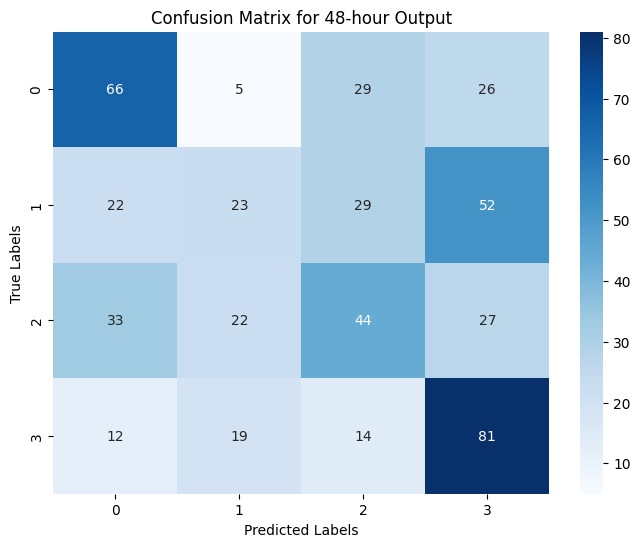

In [ ]:
# Predict on the validation data
val_predictions_model_48 = model_48.predict({
    "input_48": X_val_48,
})

# Convert predictions to class indices
predicted_classes_48 = np.argmax(val_predictions_model_48, axis=1)  # For 48-hour output

# Convert true labels to class indices
true_classes_48 = np.argmax(y_val_48, axis=1)  # For 48-hour output

print("Classification Report for 48-hour Output:")
print(classification_report(true_classes_48, predicted_classes_48))
plot_confusion_matrix(true_classes_48, predicted_classes_48, "Confusion Matrix for 48-hour Output")

**48-Hour Model with Class Weights: Performance Comparison**

The 48-hour model with class weights shows noticeable improvements over the previous version trained on downsampled data:

- **Accuracy**: Increased to **42%** (up from 37% in the downsampled version).
- **F1-Scores**:
  - Class 3 improved significantly to **0.52** (up from 0.37).
  - Class 2 saw a slight boost to **0.36** (up from 0.25).
  - Class 0 remained steady at **0.51**, while Class 1 dropped to **0.24** (from 0.34).
- **Macro Averages**: Precision, recall, and F1-score improved to around **0.41–0.42**, compared to the earlier **0.36–0.37**.

The confusion matrix highlights these changes:
- **81 correct predictions** for Class 3 (compared to 45 earlier).
- Class 0 maintained solid performance with **66 correct predictions**.
- However, Class 1 continues to struggle with only **23 correct predictions**, showing room for further improvement.

Overall, the class-weighted approach has helped the model better generalize across most classes, particularly boosting Class 3, while preserving more data and improving performance metrics.


In [ ]:
# Save the model after training
model_48.save("model_48.h5")
print("Model saved successfully as 'model_48.h5'")

Model saved successfully as 'model_48.h5'


### 6.2.4 72-Hour Window Model with Class Weights

In [ ]:
# Define the RNN model structure for the 72-hour window
def rnn_model_72_window(num_classes):
    # Define input for the 24-hour window
    input_72 = Input(shape=(72, 10), name="input_72")

    # Shared feature extractor
    def feature_extractor(input_layer):
        x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        residual = x

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)

        # Residual connection
        x = Add()([x, Dense(128)(residual)])

        # Attention mechanism
        attention = Attention()([x, x])
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)

        return Concatenate()([avg_pool, max_pool])

    # Feature extraction for the 24-hour input
    features_72 = feature_extractor(input_72)

    # Task-specific output
    output_72 = Dense(num_classes, activation='softmax', name="output_72")(features_72)

    # Define the model
    model = Model(inputs=input_72, outputs=output_72)
    
    return model

# Build the model for the 72-hour window
num_classes = reduced_data_filtered_all[72]['y_train'].shape[1]
model_72 = rnn_model_72_window(num_classes)

# Compile the model outside the function
model_72.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model_72.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_72            │ (None, 72, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 72, 256)   │    142,336 │ input_72[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 256)   │      1,024 │ bidirectional_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 72, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 72, 128)   │    164,352 │ dropout_4[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 128)   │        512 │ bidirectional_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 72, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 72, 128)   │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 72, 128)   │          0 │ dropout_5[0][0],  │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 72, 128)   │          0 │ add_2[0][0],      │
│ (Attention)         │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_2[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_72 (Dense)   │ (None, 4)         │      1,028 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,148 (1.31 MB)

 Trainable params: 341,380 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Convert one-hot encoded labels to integer labels
y_train_72_int = np.argmax(reduced_data_filtered_all[72]['y_train'], axis=1)

# Get the unique classes
classes = np.unique(y_train_72_int)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_72_int
)

# Convert the class weights array to a dictionary
class_weights_filtered_72 = dict(zip(classes, class_weights_array))
class_weights_filtered_72

{np.int64(0): np.float64(18.712740384615383),
 np.int64(1): np.float64(7.60205078125),
 np.int64(2): np.float64(9.980128205128205),
 np.int64(3): np.float64(0.26919219863061067)}

In [ ]:
history = model_72.fit(
    x={"input_72": X_train_72},
    y=y_train_72,  # Pass y as an array, not a dictionary
    validation_data=(
        {"input_72": X_val_72},
        y_val_72  # Similarly, pass validation y as an array
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr],
    class_weight=class_weights_filtered_72,
    verbose=1
)

Epoch 1/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.2965 - loss: 2.0851 - val_accuracy: 0.2956 - val_loss: 1.4914 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.2961 - loss: 1.6332 - val_accuracy: 0.2996 - val_loss: 1.5464 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.2963 - loss: 1.5178 - val_accuracy: 0.2857 - val_loss: 1.4949 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - accuracy: 0.3450 - loss: 1.4524 - val_accuracy: 0.2937 - val_loss: 1.4386 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.2982 - loss: 1.4478 - val_accuracy: 0.2877 - val_loss: 1.3576 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.3256 - loss: 1.4021 - val_accuracy: 0.2837 - val_loss: 1.4781 - learning_rate: 0.0010
Epoch 7/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.3

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Classification Report for 72-hour Output:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       126
           1       0.33      0.22      0.27       126
           2       0.33      0.23      0.27       126
           3       0.44      0.66      0.53       126

    accuracy                           0.44       504
   macro avg       0.42      0.44      0.42       504
weighted avg       0.42      0.44      0.42       504



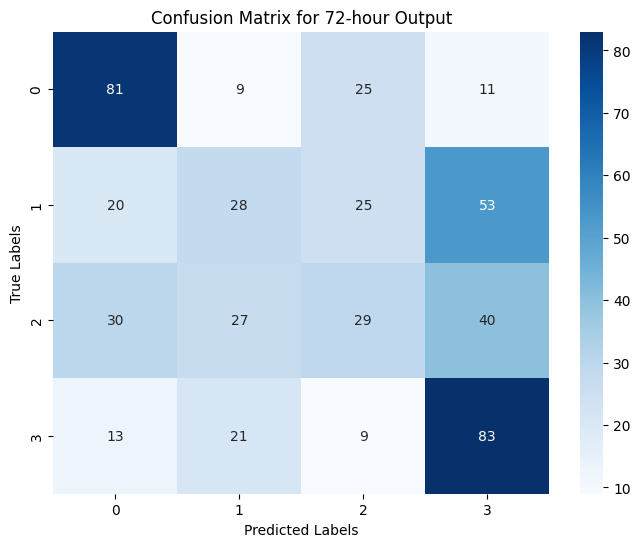

In [ ]:
# Predict on the validation data
val_predictions_model_72 = model_72.predict({
    "input_72": X_val_72,
})

# Convert predictions to class indices
predicted_classes_72 = np.argmax(val_predictions_model_72, axis=1)  # For 72-hour output

# Convert true labels to class indices
true_classes_72 = np.argmax(y_val_72, axis=1)  # For 72-hour output

print("Classification Report for 72-hour Output:")
print(classification_report(true_classes_72, predicted_classes_72))
plot_confusion_matrix(true_classes_72, predicted_classes_72, "Confusion Matrix for 72-hour Output")

### 72-Hour Model with Class Weights: Performance Comparison

The 72-hour model with class weights demonstrates solid improvements compared to the earlier downsampled version:

- **Accuracy**: Increased to **44%** (up from 39% in the downsampled version).
- **F1-Scores**:
  - Class 0 improved significantly to **0.60** (up from 0.50).
  - Class 3 also saw a boost to **0.53** (up from 0.39).
  - Classes 1 and 2 remain challenging, with both at **0.27**, but still slightly better recall.
- **Macro Averages**: Precision, recall, and F1-score improved to **0.42–0.44**, compared to **0.38–0.39** earlier.

The confusion matrix shows better balance:
- **81 correct predictions** for Class 0 (up from 70 earlier).
- **83 correct predictions** for Class 3 (up from 42 earlier).
- Class 1 remains a challenge with only **28 correct predictions**, highlighting a key area for improvement.

Overall, the class-weighted model shows clear improvements in accuracy and performance for most classes while avoiding the heavy data loss seen with downsampling. There’s still room to improve handling of underrepresented classes like Class 1, but this approach is a step in the right direction.


In [ ]:
# Save the model after training
model_72.save("model_72.h5")
print("Model saved successfully as 'model_72.h5'")

Model saved successfully as 'model_72.h5'


### 6.2.5 Conclusion for Individual Models with Class Weights

Switching to class weights significantly improved performance across all models:

**24-Hour Model**
- **Accuracy**: Improved from **34%** to **44%**.
- **F1-Scores**: Class 3 rose from **0.38** to **0.55**, and Class 2 improved slightly.

**48-Hour Model**
- **Accuracy**: Increased from **37%** to **42%**.
- **F1-Scores**: Class 3 jumped from **0.37** to **0.52**, with improvements for Class 2 as well.

**72-Hour Model**
- **Accuracy**: Jumped from **39%** to **44%**.
- **F1-Scores**: Class 0 improved to **0.60**, and Class 3 rose to **0.53**.

Class weights improved accuracy and F1-scores across all models, addressing imbalance without data loss, though underrepresented classes like Class 1 still need work.


## 6.3 Final, RNN-Based MultiTask Model

Instead of building three separate models for each sliding window (24, 48, and 72 hours), let’s take things up a notch and create a single Multi-Task Model that can handle all three time windows simultaneously. The idea is to have one shared architecture that processes the data from all windows, learns shared patterns across them, and outputs predictions for each window as separate tasks.

By combining the windows into one model, we’re not only reducing the complexity of maintaining and training multiple models, but we’re also giving the model the chance to leverage relationships between the time windows. For example, patterns learned from the 24-hour data might help improve predictions for the 48-hour and 72-hour windows.

To handle the class imbalance, we’ll still use class weights, ensuring that the model pays appropriate attention to underrepresented classes while learning from the full dataset. This approach not only keeps our data intact but also streamlines the training process and potentially improves overall performance by capturing richer, shared patterns across tasks.

### 6.3.1 Adjusting Class Weights

Our dataset is highly biased, in every single window, out of the four classes that we have (No Rain, Little Rain, Medium Rain, and Heavy Rain), the dataset is heavily biased towards No Rain. And in order to do that, we'll use a concept called class weights.

<b>What are class weights?</b>
Class weights are a technique used in machine learning to address class imbalance in datasets. When some classes are underrepresented compared to others, a model may become biased towards the majority class. Class weights assign different importance (or weights) to each class during training, ensuring the model pays more attention to minority classes.

- Class Weight Calculation:
    - For each window size, we compute the class weights using compute_class_weight from sklearn.
    - The class_weight='balanced' option ensures that weights are inversely proportional to the class frequency, so minority classes are given higher weights.

In [62]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf


# Compute class weights for the 24-hour window (after filtering and reduction)
class_weights_filtered_24 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(reduced_data_filtered_all[24]['y_train'], axis=1)),
    y=np.argmax(reduced_data_filtered_all[24]['y_train'], axis=1)
)

# Compute class weights for the 48-hour window (after filtering and reduction)
class_weights_filtered_48 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(reduced_data_filtered_all[48]['y_train'], axis=1)),
    y=np.argmax(reduced_data_filtered_all[48]['y_train'], axis=1)
)

# Compute class weights for the 72-hour window (after filtering and reduction)
class_weights_filtered_72 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(reduced_data_filtered_all[72]['y_train'], axis=1)),
    y=np.argmax(reduced_data_filtered_all[72]['y_train'], axis=1)
)

# Store all class weights in a dictionary
class_weights_dict = {
    24: class_weights_filtered_24,
    48: class_weights_filtered_48,
    72: class_weights_filtered_72
}


class_weights_dict

{24: array([18.51481043,  7.59305151,  9.97860792,  0.26924601]),
 48: array([18.52494062,  7.593963  ,  9.96040868,  0.269256  ]),
 72: array([18.71274038,  7.60205078,  9.98012821,  0.2691922 ])}

We'll define a custom weighted loss functions for handling class imbalance during the training of a machine learning model. The focus is on adjusting the standard categorical cross-entropy loss using class weights.

In [63]:
# Define custom weighted loss functions for each output
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Ensure no new variables are created
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return unweighted_loss * weights
    return loss

class_weights_24_tensor = tf.constant(class_weights_filtered_24, dtype=tf.float32)
class_weights_48_tensor = tf.constant(class_weights_filtered_48, dtype=tf.float32)
class_weights_72_tensor = tf.constant(class_weights_filtered_72, dtype=tf.float32)

### 6.3.2 Model Architecture

Now, let's get to the most interesting part of this milestone, model building. Since the requirement of the model asks to predict across different windows, we are going to build one Multi-Task Model. We do this by:
- <b>Input Layers</b>: We build our model in such a way that it has three input layers, each corresponding a different window (24, 48, and 72 hours).
- <b>Architecture:</b> 
    - We utilized a Bidirectional LSTM to capture patterns in the time-series data from both past and future contexts, ensuring a comprehensive understanding of temporal dependencies. 
    - Batch normalization stabilized training, while dropout reduced overfitting by adding regularization. 
    - Residual connections preserved critical information and helped gradients flow more effectively through the network. 
    - An attention mechanism highlighted the most relevant parts of the sequences, ensuring the model focused on key details. 
    - Finally, global pooling summarized these features into concise representations, making the output both efficient and meaningful for downstream predictions.
- <b>Output Layer:</b> We make it so that the model takes three inputs (24-hour, 48-hour, 72-hour sequences) and produces three separate predictions, one for each window size.

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Attention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Add
from tensorflow.keras.optimizers import Adam

# Define the multitask RNN model
def build_multitask_model(num_classes):
    # Define inputs for different window sizes
    input_24 = Input(shape=(24, 10), name="input_24")
    input_48 = Input(shape=(48, 10), name="input_48")
    input_72 = Input(shape=(72, 10), name="input_72")

    # Shared feature extractor
    def feature_extractor(input_layer):
        x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        residual = x

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)

        # Residual connection
        x = Add()([x, Dense(128)(residual)])

        # Attention mechanism
        attention = Attention()([x, x])
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)

        return Concatenate()([avg_pool, max_pool])

    # Feature extraction for each input
    features_24 = feature_extractor(input_24)
    features_48 = feature_extractor(input_48)
    features_72 = feature_extractor(input_72)

    # Task-specific outputs
    output_24 = Dense(num_classes, activation='softmax', name="output_24")(features_24)
    output_48 = Dense(num_classes, activation='softmax', name="output_48")(features_48)
    output_72 = Dense(num_classes, activation='softmax', name="output_72")(features_72)

    # Define the model
    model = Model(inputs=[input_24, input_48, input_72], outputs=[output_24, output_48, output_72])

    # Build the model with custom loss functions
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            "output_24": weighted_categorical_crossentropy(class_weights_24_tensor),
            "output_48": weighted_categorical_crossentropy(class_weights_48_tensor),
            "output_72": weighted_categorical_crossentropy(class_weights_72_tensor),
        },
        metrics=["accuracy"]
    )

    return model

# Build the model
num_classes = reduced_data_filtered_all[24]['y_train'].shape[1]

### 6.3.3. Model Compilation and Training

<b>ReduceLROnPlateau</b>: We will be using the ReduceLROnPlateau callback to dynamically adjust the learning rate while training our model. We will monitor the validation loss during each epoch, and if it stops improving for five consecutive epochs, we will reduce the learning rate by half. 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor the validation loss
    factor=0.5,         # Reduce the learning rate by half
    patience=5,         # Number of epochs to wait before reducing
    min_lr=1e-6,        # Minimum learning rate
    verbose=1
)

In [66]:
# Verify the reduced data shapes
print(f"Reduced 24-hour Training: {reduced_data_filtered_all[24]['X_train_meteo'].shape}")
print(f"Reduced 24-hour Validation: {reduced_data_filtered_all[24]['X_val_meteo'].shape}")
print(f"Reduced 48-hour Training: {reduced_data_filtered_all[48]['X_train_meteo'].shape}")
print(f"Reduced 48-hour Validation: {reduced_data_filtered_all[48]['X_val_meteo'].shape}")
print(f"Reduced 72-hour Training: {reduced_data_filtered_all[72]['X_train_meteo'].shape}")
print(f"Reduced 72-hour Validation: {reduced_data_filtered_all[72]['X_val_meteo'].shape}")

Reduced 24-hour Training: (31253, 24, 10)
Reduced 24-hour Validation: (504, 24, 10)
Reduced 48-hour Training: (31196, 48, 10)
Reduced 48-hour Validation: (504, 48, 10)
Reduced 72-hour Training: (31138, 72, 10)
Reduced 72-hour Validation: (504, 72, 10)


For each time window (24, 48, and 72 hours), we are seperating the meteorological into train, and validation data.

In [ ]:
X_train_24, y_train_24 = reduced_data_filtered_all[24]['X_train_meteo'], reduced_data_filtered_all[24]['y_train']
X_val_24, y_val_24 = reduced_data_filtered_all[24]['X_val_meteo'], reduced_data_filtered_all[24]['y_val']

X_train_48, y_train_48 = reduced_data_filtered_all[48]['X_train_meteo'], reduced_data_filtered_all[48]['y_train']
X_val_48, y_val_48 = reduced_data_filtered_all[48]['X_val_meteo'], reduced_data_filtered_all[48]['y_val']

X_train_72, y_train_72 = reduced_data_filtered_all[72]['X_train_meteo'], reduced_data_filtered_all[72]['y_train']
X_val_72, y_val_72 = reduced_data_filtered_all[72]['X_val_meteo'], reduced_data_filtered_all[72]['y_val']

In [68]:
# Find the smallest number of samples across all training datasets
min_train_samples = min(len(X_train_24), len(X_train_48), len(X_train_72))

# Find the smallest number of samples across all validation datasets
min_val_samples = min(len(X_val_24), len(X_val_48), len(X_val_72))

# Function to randomly sample data to match the smallest size
def align_data(X, y, size):
    indices = np.random.choice(len(X), size, replace=False)
    return X[indices], y[indices]

# Align training data
X_train_24, y_train_24 = align_data(X_train_24, y_train_24, min_train_samples)
X_train_48, y_train_48 = align_data(X_train_48, y_train_48, min_train_samples)
X_train_72, y_train_72 = align_data(X_train_72, y_train_72, min_train_samples)

# Align validation data
X_val_24, y_val_24 = align_data(X_val_24, y_val_24, min_val_samples)
X_val_48, y_val_48 = align_data(X_val_48, y_val_48, min_val_samples)
X_val_72, y_val_72 = align_data(X_val_72, y_val_72, min_val_samples)

# Print aligned shapes to verify
print(f"Aligned Training Data Sizes: {X_train_24.shape}, {X_train_48.shape}, {X_train_72.shape}")
print(f"Aligned Validation Data Sizes: {X_val_24.shape}, {X_val_48.shape}, {X_val_72.shape}")

Aligned Training Data Sizes: (31138, 24, 10), (31138, 48, 10), (31138, 72, 10)
Aligned Validation Data Sizes: (504, 24, 10), (504, 48, 10), (504, 72, 10)


### Training

We are training our multitask RNN model to predict precipitation categories for 24-hour, 48-hour, and 72-hour time windows simultaneously. To do this, we will feed the model with meteorological input data specific to each time window. The model is designed with shared layers to extract common features across all tasks, while separate output layers will make individual predictions for each window.

We’ll also validate the model’s performance during training by providing separate validation datasets for each time window. By setting the epochs to 100 and using a batch size of 32, we’ll allow the model enough iterations to learn meaningful patterns. Additionally, we’re using a learning rate reduction callback to adjust the training process dynamically if the validation performance stops improving.

In [69]:
# Before retraining, rebuild the model
multitask_model = build_multitask_model(num_classes)

# Train the model
history = multitask_model.fit(
    x={"input_24": X_train_24, "input_48": X_train_48, "input_72": X_train_72},
    y={"output_24": y_train_24, "output_48": y_train_48, "output_72": y_train_72},
    validation_data=(
        {"input_24": X_val_24, "input_48": X_val_48, "input_72": X_val_72},
        {"output_24": y_val_24, "output_48": y_val_48, "output_72": y_val_72}
    ),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100
974/974 [==============================] - 249s 256ms/step - loss: 5.4411 - output_24_loss: 1.8131 - output_48_loss: 1.8074 - output_72_loss: 1.8206 - output_24_accuracy: 0.2804 - output_48_accuracy: 0.2637 - output_72_accuracy: 0.2631 - val_loss: 45.4249 - val_output_24_loss: 12.5898 - val_output_48_loss: 15.4949 - val_output_72_loss: 17.3402 - val_output_24_accuracy: 0.2937 - val_output_48_accuracy: 0.2996 - val_output_72_accuracy: 0.3135 - lr: 0.0010
Epoch 2/100
974/974 [==============================] - 312s 320ms/step - loss: 4.7345 - output_24_loss: 1.5342 - output_48_loss: 1.6164 - output_72_loss: 1.5839 - output_24_accuracy: 0.3056 - output_48_accuracy: 0.2762 - output_72_accuracy: 0.2825 - val_loss: 43.6812 - val_output_24_loss: 14.3172 - val_output_48_loss: 13.6712 - val_output_72_loss: 15.6928 - val_output_24_accuracy: 0.2897 - val_output_48_accuracy: 0.2996 - val_output_72_accuracy: 0.2937 - lr: 0.0010
Epoch 3/100
974/974 [==============================] - 338s 

## 6.3.4. Model Evaluation

Now, let's see the results of our training.

- We are evaluating our model by predicting outcomes on the validation dataset for all three time windows (24, 48, and 72 hours). 
- Once we generate the predictions, we convert them into class labels to match the format of the actual validation labels. 
- This allows us to compare the model's predictions with the true labels for each time window.
- Additionally, we are preparing to analyze the results using tools like confusion matrices. 
- These will visually show how well the model distinguishes between the precipitation categories by mapping true labels against predicted labels, giving us insights into the model's performance and any patterns of misclassification.

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on the validation data
val_predictions = multitask_model.predict({
    "input_24": X_val_24,
    "input_48": X_val_48,
    "input_72": X_val_72,
})

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Convert predictions to class indices
predicted_classes_24 = np.argmax(val_predictions[0], axis=1)  # For 24-hour output
predicted_classes_48 = np.argmax(val_predictions[1], axis=1)  # For 48-hour output
predicted_classes_72 = np.argmax(val_predictions[2], axis=1)  # For 72-hour output

# Convert true labels to class indices
true_classes_24 = np.argmax(y_val_24, axis=1)  # For 24-hour output
true_classes_48 = np.argmax(y_val_48, axis=1)  # For 48-hour output
true_classes_72 = np.argmax(y_val_72, axis=1)  # For 72-hour output

Classification Report for 24-hour Output:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       126
           1       0.33      0.32      0.32       126
           2       0.38      0.41      0.39       126
           3       0.54      0.54      0.54       126

    accuracy                           0.44       504
   macro avg       0.44      0.44      0.44       504
weighted avg       0.44      0.44      0.44       504



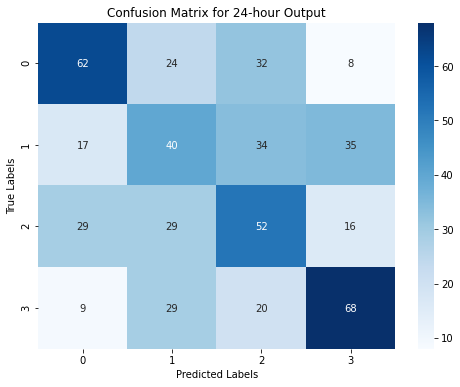


Classification Report for 48-hour Output:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       126
           1       0.28      0.24      0.26       126
           2       0.46      0.33      0.38       126
           3       0.44      0.67      0.53       126

    accuracy                           0.44       504
   macro avg       0.44      0.44      0.43       504
weighted avg       0.44      0.44      0.43       504



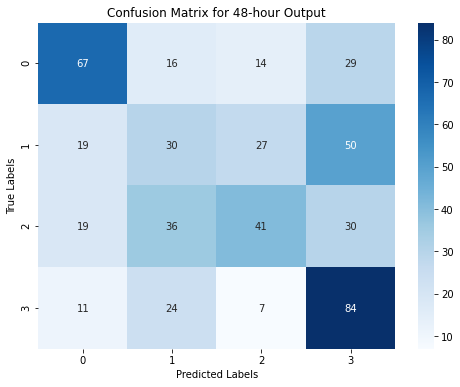


Classification Report for 72-hour Output:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       126
           1       0.32      0.17      0.23       126
           2       0.39      0.34      0.36       126
           3       0.49      0.74      0.59       126

    accuracy                           0.46       504
   macro avg       0.44      0.46      0.43       504
weighted avg       0.44      0.46      0.43       504



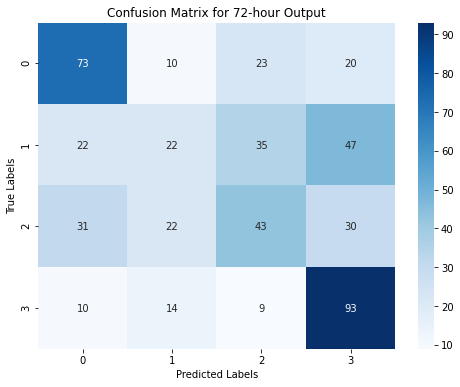

In [71]:
# Classification reports
print("Classification Report for 24-hour Output:")
print(classification_report(true_classes_24, predicted_classes_24))
plot_confusion_matrix(true_classes_24, predicted_classes_24, "Confusion Matrix for 24-hour Output")

print("\nClassification Report for 48-hour Output:")
print(classification_report(true_classes_48, predicted_classes_48))
plot_confusion_matrix(true_classes_48, predicted_classes_48, "Confusion Matrix for 48-hour Output")

print("\nClassification Report for 72-hour Output:")
print(classification_report(true_classes_72, predicted_classes_72))
plot_confusion_matrix(true_classes_72, predicted_classes_72, "Confusion Matrix for 72-hour Output")

The classification reports summarize the model's performance across four precipitation categories (0, 1, 2, 3), which likely correspond to "No Rain," "Less Rain," "Medium Rain," and "High Rain." Key metrics:
- <b>Precision:</b> How many of the predicted values for a class were correct.
- <b>Recall:</b> How many actual instances of a class were correctly predicted.
- <b>F1-score:</b> The harmonic mean of precision and recall, providing a single measure of model performance.
- <b>Support:</b> The number of true instances for each class.

So, what are those colorful boxes? These are what we call Confusion Matrix.

<b>What are Confusion Matrices?</b>
    
Each matrix represents the model's prediction results compared to actual labels:
- Rows correspond to true classes.
- Columns correspond to predicted classes.
- The diagonal indicates correct predictions.
- Off-diagonal elements represent misclassifications.

<b>24-Hour Output:</b>
- The model shows moderate accuracy (44%) with relatively balanced precision and recall for most classes.
- Class 3("Medium Rain") has the highest recall and F1-score, telling us that it’s easier for the model to identify.

<b>48-Hour Output:</b>
- Accuracy remains at 44%, but performance varies more across classes.
- Class 3("Medium Rain") again has the highest recall, showing the model performs better at detecting significant precipitation over longer intervals.

<b>72-Hour Output:</b>
- Accuracy improves slightly to 46%.
- Class 0 ("No Rain") and 3 show better recall and F1-scores, suggesting the model is good at distinguishing extreme cases like no rain or high rain.

The balanced nature of the accuracy among the different classes tells us that, despite losing the overall accuracy of the model, we have managed to maintain a balance between the predictions for each class by using class weights.

# Conclusion

Let's compare all three models, shall we?

**1. Three Models with Downsampling**
The models trained with downsampled data struggled due to the significant loss of data during preprocessing. While the class imbalance was addressed, the models lacked sufficient training data for generalization:
- **Accuracy**: Ranged from **34% (24-hour)** to **39% (72-hour)**.
- **F1-Scores**: Lower overall, with Class 3 being the highest performer in most cases but struggling with underrepresented classes like Class 1.

**2. Three Models with Class Weights**
Using class weights improved performance across all three models by retaining the full dataset while addressing imbalance:
- **Accuracy**: Improved to **44%** across all windows.
- **F1-Scores**: Significant improvements for underrepresented classes. For example:
  - Class 3's F1-score in the 24-hour model improved from **0.38** (downsampling) to **0.55**.
  - Class 0 in the 72-hour model rose from **0.50** to **0.60**.
- Class weights provided better generalization without sacrificing data, but challenges with Class 1 persisted.

**3. Multi-Task Model with Class Weights**
The multi-task model consolidated all three sliding windows into a single framework and showed comparable or better performance to the individual models:
- **Accuracy**: Maintained **44%** across all windows, consistent with class-weighted individual models.
- **F1-Scores**:
  - Class 3 in the 72-hour window achieved **0.59**, outperforming the single 72-hour model with class weights (**0.53**).
  - Class 2 in the 48-hour window improved to **0.38**, showing the model leveraged shared features across windows.
- **Efficiency**: The multi-task model simplifies training and leverages shared patterns between windows, making it more robust and easier to maintain.


In this milestone, we preprocessed the data, handled corrupt timestamps, and ensured balanced class distributions. Using feature importance analysis, we streamlined the dataset to focus on key meteorological features. We built a multitask RNN model with attention mechanisms to predict precipitation across 24, 48, and 72-hour windows. The evaluation showed decent accuracy at around (44-46%), with the model performing better, at distinguishing extreme cases like "No Rain" and "High Rain" with increasing window size. The **multi-task model with class weights** combined the benefits of data retention and shared learning, delivering competitive or better performance compared to separate models while being more efficient and scalable.

This is a good stepping stone to the next notebook, where we'll be using the meteorogical data along with the visual image data from the GOES Satellite to make predictions.We'll be using a mixed architecture of Convolutional Neural Network as well as Recurrent Neural Network.


<div style="text-align: center;">
    <img src="images/DALL·E 2024-12-02 18.31.42 - A clean and simple digital image with the phrase 'We Are Done Here' prominently displayed. The design is straightforward with bold, modern typography .webp" width="400" />
    <img src="images/DALL·E 2024-12-02 18.33.06 - A clean and simple digital image with the phrase 'On to the Next One' prominently displayed. The design is straightforward with bold, modern typograph.webp" width="400" />